# 이커머스 고객 세분화 경진대회 - KHUIE

- 분석 목표 : 이커머스 환경에서 발생하는 데이터를 활용해 고객들을 효과적으로 세분화하고 고객들의 행동패턴, 구매 경향을 이해하여 기업에 비즈니스 솔루션 제공

- 분석 목적 정의 : 문제 해결 능력, RFM 분석 및 코호트 분석 활용해 고객 세그먼트화

- 분석 기법 적용 

1. RFM Analysis
    - Recency - 거래의 최근성 : 고객이 얼마나 최근에 구입을 진행했는가? (고객의 마지막 거래날짜 - 마지막 이전 거래날짜)
    - Frequency - 거래빈도 : 고객이 얼마나 빈번하게 우리 이커머스로부터 제품을 구매했는가? (2019년 거래 횟수)
    - Monetary - 거래규모 : 고객이 구입했던 총 금액은 얼마인가? (2019년 거래 주문금액 총합)
    
    -> RFM 분석을 통해 5점 척도로 고객 세그먼트 진행하여 매출에 긍정적인 영향을 끼치는 고객들 타게팅 후 구매 경향 분석하기.
    단, 1년 중 하루만 결제를 진행한 인원 734名에 한해 RFM이 아닌 R을 제외한 분석을 수행하여 Onetime 고객군으로 지정해 분석 수행.
  
2. Cohort Analysis
    - 고객 등급 별 코호트 분석 수행해 매출 증대를 일으킬 수 있는 요인 발굴.
    - 이후 매출 증진 효과 가설 검정을 통해 솔루션 제시

# 라이브러리, 데이터 로딩

In [1]:
import pandas as pd
import numpy as np
import warnings 
import random
import math
import os
import datetime
warnings.filterwarnings(action = 'ignore')
warnings.filterwarnings('ignore')

# 시각화를 위한 라이브러리 호출
import matplotlib
from matplotlib import font_manager, rc
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import seaborn as sns
# 한글 출력 시 폰트 깨짐 방지
font_path = 'C:/Windows/Fonts/malgun.ttf'
font_prop = fm.FontProperties(fname=font_path)
font_name = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font_name)
# - 출력 시 폰트 깨짐 방지
matplotlib.rcParams['axes.unicode_minus'] = False


DATA_DIR = 'C:/Users/wnrrh/desktop/data/이커머스 고객 세분화 분석 아이디어 공모전'
customer = pd.read_csv(f'{DATA_DIR}/Customer_info.csv')
discount = pd.read_csv(f'{DATA_DIR}/Discount_info.csv')
marketing = pd.read_csv(f'{DATA_DIR}/Marketing_info.csv')
onlinesales = pd.read_csv(f'{DATA_DIR}/Onlinesales_info.csv')
tax = pd.read_csv(f'{DATA_DIR}/Tax_info.csv')

## 날짜 데이터 전처리

In [2]:
# 날짜 컬럼 처리
def convert_date_and_feature_engineering(df):
    # 요일 컬럼 추가
    # 2019년의 시작 날짜와 끝 날짜
    start_date = datetime.date(2019, 1, 1)
    end_date = datetime.date(2019, 12, 31)
    date_range = pd.date_range(start=start_date, end=end_date)
    date_df_2019 = pd.DataFrame(date_range, columns=['Date'])
    # 요일 컬럼 추가
    date_df_2019['Weekday'] = date_df_2019['Date'].dt.day_name()
    date_df_2019['Date'] = date_df_2019['Date'].astype('str')
    if '날짜' in df.columns:
        df = pd.merge(df, date_df_2019, left_on = ['날짜'], right_on = ['Date'], how = 'left')
    # Onlinesales_info 날짜 정보 변경
    if '거래날짜' in df.columns:
        df = pd.merge(df, date_df_2019, left_on = ['거래날짜'], right_on = ['Date'], how = 'left')
        df.rename(columns = {'거래날짜':'날짜'}, inplace=True)
    if '날짜' in df.columns:
        df['연'] = df['날짜'].str.slice(0, 4)
        df['월'] = df['날짜'].str.slice(5, 7)
        df['일'] = df['날짜'].str.slice(8, 10)
        df.drop(['날짜'], axis=1, inplace=True)
    # Marketing_info 날짜 정보 변경
    month = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    if month == list(df['월'].unique()):
        mapping_month = {'Jan': '01', 'Feb': '02', 'Mar': '03', 'Apr': '04', 'May': '05', 'Jun': '06',
                         'Jul': '07', 'Aug': '08', 'Sep': '09', 'Oct': '10', 'Nov': '11', 'Dec': '12'}
        df['월'] = df['월'].map(mapping_month)
    if '연' in df.columns:
        df['연'] = df['연'].astype('int')
    if '월' in df.columns:
        df['월'] = df['월'].astype('int')
    if '일' in df.columns:
        df['일'] = df['일'].astype('int')
    # discount 정보 전처리 (쿠폰이름 / 할인율만 남기기)
    if '쿠폰코드' in df.columns:
        df['쿠폰코드'] = df['쿠폰코드'].apply(lambda x: x[:-2])
    
    if 'Date' in df.columns:
        df.drop(['Date'], axis=1, inplace=True)
    return df
discount_df = convert_date_and_feature_engineering(discount)
onlinesales_df = convert_date_and_feature_engineering(onlinesales)
marketing_df = convert_date_and_feature_engineering(marketing)

## 온/오프라인 구분 여부 Check.

In [3]:
to_merge_online = onlinesales_df[['고객ID']]
to_merge_online['온라인 구매여부'] = 1
# 중복된 로우 제거
to_merge_online = to_merge_online.drop_duplicates()
customer_onoff = pd.merge(customer, to_merge_online, on = ['고객ID'], how='left')
print(customer_onoff.head(5))
print(customer_onoff['온라인 구매여부'].value_counts())

        고객ID 성별        고객지역  가입기간  온라인 구매여부
0  USER_1358  남     Chicago    12         1
1  USER_0190  남  California    43         1
2  USER_0066  남     Chicago    33         1
3  USER_0345  여  California    30         1
4  USER_0683  남  California    49         1
1    1468
Name: 온라인 구매여부, dtype: int64


✅ Data Insights.

- 온라인 구매여부를 판단해보니 주어진 고객들은 전부 온라인 구매 이력이 있음.
- 따라서 온/오프라인 유저로 구분해서 진행할 필요 없이 온라인 마케팅을 대상으로 진행.

✨ Insight

-> 결국 Onlinesales_info 테이블에 모든 데이터 결합시켜서 지표 뽑아내기.

## 이커머스 고객들 가입기간 코호트 지정

In [4]:
customer.describe()

,가입기간
count,1468.000000
mean,25.912125
std,13.959667
min,2.000000
25%,14.000000
50%,26.000000
75%,38.000000
max,50.000000


✅ Data Insights.

- 가입기간의 경우 범주가 12개월 단위로 고객들의 분포가 25% 씩 규칙성 있는 패턴을 확인할 수 있음
> 이를 4개의 코호트로 분리해 볼 수 있음

In [5]:
bins = [1, 14, 26, 38, 50]
labels = ['1년', '2년', '3년', '4년']
customer['가입기간_코호트'] = pd.cut(customer['가입기간'], bins=bins, labels=labels)

## 온라인 거래 취합

In [6]:
# 온라인 판매 정보 & 제품 카테고리 월별 할인 정보 병합
online_sales = pd.merge(onlinesales_df, discount_df, on = ['월', '제품카테고리'], how='left')
# 온라인 판매 정보 & 세금 정보 병합
online_sales = pd.merge(online_sales, tax, on = ['제품카테고리'], how = 'left')
# 온라인 판매 정보 & 고객 정보 병합
online_sales = pd.merge(online_sales, customer, on = ['고객ID'], how = 'left')
# 온라인 판매 정보 & 마케팅 프로모션 병합
online = pd.merge(online_sales, marketing_df, on = ['연', '월', '일', 'Weekday'], how = 'left')
# 거래날짜만 추가.
online = pd.merge(online, onlinesales, on = ['고객ID', '거래ID', '제품ID', '제품카테고리', '수량', '평균금액', '배송료', '쿠폰상태'])

# 평균 구매 주기 확인용도
online['거래날짜'] = pd.to_datetime(online['거래날짜'])

# 결측치 처리
online['쿠폰코드'] = online['쿠폰코드'].fillna('Na')
online['할인율'] = online['할인율'].fillna(0)

In [7]:
online.head(5)

,고객ID,거래ID,제품ID,제품카테고리,수량,평균금액,배송료,쿠폰상태,Weekday,연,...,쿠폰코드,할인율,GST,성별,고객지역,가입기간,가입기간_코호트,오프라인비용,온라인비용,거래날짜
0,USER_1358,Transaction_0000,Product_0981,Nest-USA,1,153.71,6.5,Used,Tuesday,2019,...,ELEC,10.0,0.10,남,Chicago,12,1년,4500,2424.5,2019-01-01
1,USER_1358,Transaction_0001,Product_0981,Nest-USA,1,153.71,6.5,Used,Tuesday,2019,...,ELEC,10.0,0.10,남,Chicago,12,1년,4500,2424.5,2019-01-01
2,USER_1358,Transaction_0002,Product_0904,Office,1,2.05,6.5,Used,Tuesday,2019,...,OFF,10.0,0.10,남,Chicago,12,1년,4500,2424.5,2019-01-01
3,USER_1358,Transaction_0003,Product_0203,Apparel,5,17.53,6.5,Not Used,Tuesday,2019,...,SALE,10.0,0.18,남,Chicago,12,1년,4500,2424.5,2019-01-01
4,USER_1358,Transaction_0003,Product_0848,Bags,1,16.50,6.5,Used,Tuesday,2019,...,AIO,10.0,0.18,남,Chicago,12,1년,4500,2424.5,2019-01-01


# 매출 및 영업이익 정의

🎈 가정

1. 판매 중인 상품에 Tax가 붙지 않는다.
2. 현재 이커머스 기업은 배송 서비스까지 담당하고 있다.
3. 영업이익 계산 시 할인금액이 제거된다.

> 매출 집계 :
> 매출 = (((상품의 평균금액 * 상품 수량) + 배송료) * 세금)

> 영업이익 집계 : 
> 영업이익 = (((상품의 평균금액 * 상품 수량) + 배송료) / 세금) - 상품별 할인금액

> 순이익 집계 :
> 순이익 = 영업이익 - 온/오프라인 비용

## 쿠폰 적용해 매출 계산

In [8]:
online['쿠폰상태'].value_counts()

Clicked     26926
Used        17904
Not Used     8094
Name: 쿠폰상태, dtype: int64

✅ Data Insights.

쿠폰 상태 여부는 다음과 같음. (전체적으로 30% 정도만 쿠폰을 사용 중.)

- Clicked : 쿠폰사용여부를 클릭했지만 사용하진 않음.
- Used : 쿠폰을 실제로 사용함.
- Not Used : 쿠폰 사용여부 클릭 여부를 떠나 아예 사용하지 않음.

> 쿠폰사용하지 않은 경우 할인금액은 0

In [9]:
# 고객 별 거래 한 건 당 발생한 금액 처리 : 주문 금액 컬럼 생성
online['주문금액'] = online['평균금액'] * online['수량']

# 할인금액을 계산, 쿠폰 사용하지 않은 경우 할인금액은 0
used_coupon = online.index[online['쿠폰상태'] == 'Used']
online.loc[used_coupon, '할인금액'] = online.loc[used_coupon, '주문금액'] * (online.loc[used_coupon, '할인율'] / 100)
online['할인금액'].fillna(0, inplace=True)
# 매출 및 영업이익 계산
online['매출'] = (online['주문금액'] + online['배송료']) * (1 + online['GST'])
online['영업이익'] = (online['매출'] / (1 + online['GST'])) - online['할인금액']

In [10]:
online.head(5)

,고객ID,거래ID,제품ID,제품카테고리,수량,평균금액,배송료,쿠폰상태,Weekday,연,...,고객지역,가입기간,가입기간_코호트,오프라인비용,온라인비용,거래날짜,주문금액,할인금액,매출,영업이익
0,USER_1358,Transaction_0000,Product_0981,Nest-USA,1,153.71,6.5,Used,Tuesday,2019,...,Chicago,12,1년,4500,2424.5,2019-01-01,153.71,15.371,176.231,144.839
1,USER_1358,Transaction_0001,Product_0981,Nest-USA,1,153.71,6.5,Used,Tuesday,2019,...,Chicago,12,1년,4500,2424.5,2019-01-01,153.71,15.371,176.231,144.839
2,USER_1358,Transaction_0002,Product_0904,Office,1,2.05,6.5,Used,Tuesday,2019,...,Chicago,12,1년,4500,2424.5,2019-01-01,2.05,0.205,9.405,8.345
3,USER_1358,Transaction_0003,Product_0203,Apparel,5,17.53,6.5,Not Used,Tuesday,2019,...,Chicago,12,1년,4500,2424.5,2019-01-01,87.65,0.000,111.097,94.150
4,USER_1358,Transaction_0003,Product_0848,Bags,1,16.50,6.5,Used,Tuesday,2019,...,Chicago,12,1년,4500,2424.5,2019-01-01,16.50,1.650,27.140,21.350


In [11]:
online['연'].value_counts()

2019    52924
Name: 연, dtype: int64

## 제품별 최고 매출 확인

In [12]:
online.groupby(['제품카테고리'])[['매출', '영업이익']].sum().sort_values(by = ['매출'], ascending = False)

,매출,영업이익
제품카테고리,,
Nest-USA,2.919227e+06,2483281.601
Apparel,9.062521e+05,728529.501
Nest,5.609901e+05,496626.488
Office,4.127665e+05,356172.781
Drinkware,2.959865e+05,238682.235
Bags,2.088122e+05,168002.307
Lifestyle,1.387938e+05,112761.447
Notebooks & Journals,1.290399e+05,117342.644
Nest-Canada,8.119468e+04,69578.232


## 고객 단위 지표 집계

In [13]:
# 고객별 매출, 영업이익, 총거래수 집계
customer_sales = online.groupby(['고객ID'])[['주문금액','배송료', '할인금액', '매출', '영업이익']].sum().reset_index()
customer_count = online.groupby(['고객ID']).size().reset_index(name='거래수')

# 고객별 평균 구매 주기 확인
customer_groups = online.groupby('고객ID')
sorted_orders = customer_groups.apply(lambda x: x.sort_values('거래날짜'))
# 같은 날 거래 건 중복 제거
sorted_orders = sorted_orders.drop_duplicates(subset=['고객ID', '거래날짜'])
purchase_intervals = []
for c, orders in sorted_orders.groupby(level=0):
    order_dates = orders['거래날짜']
    time_intervals = order_dates.diff().dropna()
    average_interval = time_intervals.mean()
    purchase_intervals.append((c, average_interval))
average_purchase_intervals = pd.DataFrame(purchase_intervals, columns=['고객ID', '평균구매주기'])
average_purchase_intervals['평균구매주기'] = average_purchase_intervals['평균구매주기'].dt.days
average_purchase_intervals['평균구매주기'] = average_purchase_intervals['평균구매주기'].fillna(0).astype(int)

# 고객별 최근 구매 주기 확인
df_sorted = online.sort_values(by=['고객ID', '거래날짜'])
df_sorted = df_sorted[['고객ID', '거래날짜']]
df_sorted = df_sorted.drop_duplicates()
recent_purchase_intervals = df_sorted.groupby('고객ID')['거래날짜'].diff().dt.days
recent_purchase_intervals = pd.DataFrame(recent_purchase_intervals)
recent_purchase_intervals.rename(columns = {'거래날짜':'최근구매주기'},inplace=True)
df_sorted = pd.merge(df_sorted, recent_purchase_intervals, left_index=True, right_index=True)
cleaned_df = df_sorted.drop_duplicates(subset='고객ID', keep='last')
# cleaned_df.drop(['거래날짜'],axis=1,inplace=True)
cleaned_df['최근구매주기'].fillna(0, inplace=True)
cleaned_df['최근구매주기'] = cleaned_df['최근구매주기'].astype('int')

# 고객별 지표 집계
customer_df = pd.merge(customer,customer_sales,on=['고객ID']).merge(customer_count,on=['고객ID']).merge(average_purchase_intervals, on=['고객ID']).merge(cleaned_df, on = ['고객ID'])
rfm_df = customer_df[['고객ID', '주문금액', '배송료', '할인금액', '매출', '영업이익', '거래수', '평균구매주기', '거래날짜', '최근구매주기']]
rfm_df.rename(columns={'거래날짜' : '최근구매일'}, inplace=True)

# RFM 분석 수행
rfm = rfm_df[['고객ID', '주문금액', '거래수', '최근구매주기', '매출']]
rfm.rename(columns = {'주문금액': 'Monetary', '거래수':'Frequency', '최근구매주기':'Recency'}, inplace=True)

In [14]:
rfm_df

,고객ID,주문금액,배송료,할인금액,매출,영업이익,거래수,평균구매주기,최근구매일,최근구매주기
0,USER_1358,34551.40,3162.62,1030.400,42112.3005,36683.620,297,2,2019-01-26,2
1,USER_0190,3048.79,315.96,295.239,3715.5339,3069.511,44,175,2019-12-18,139
2,USER_0066,2361.48,757.27,93.864,3523.2989,3024.886,42,213,2019-08-02,213
3,USER_0345,1.24,6.50,0.000,9.1332,7.740,1,0,2019-01-01,0
4,USER_0683,1043.72,64.38,224.316,1224.0684,883.784,6,48,2019-08-30,16
...,...,...,...,...,...,...,...,...,...,...
1463,USER_0513,506.88,55.50,62.172,621.9316,500.208,9,1,2019-12-31,1
1464,USER_0167,3002.01,135.99,111.924,3421.5300,3026.076,19,0,2019-12-31,0
1465,USER_0845,735.29,32.50,5.931,847.1906,761.859,5,0,2019-12-31,0
1466,USER_0504,1108.99,52.00,60.240,1255.3201,1100.750,8,0,2019-12-31,0


✅ Data Insights.

변수 설명
- 고객ID : 고객 고유 ID
- 주문금액 : 고객별 1년 단위 총 (평균금액*수량)의 합
- 배송료 : 고객별 1년 단위 배송료 총합
- 할인금액 : 고객별 1년 단위 쿠폰 사용해 할인받은 금액의 합
- 매출 : 고객별 1년 단위 회사가 얻은 매출
- 영업이익 : 고객별 1년 단위 회사가 얻은 영업이익
- 거래수 : 고객별 1년 단위 총 거래수
- 평균구매주기 : 같은 날 거래건 제외 고객당 1년에 평균 구매한 주기.
- 최근구매일 : 고객별 가장 최근 거래한 날짜
- 최근구매주기 : 고객당 (가장 마지막에 거래한 날짜 - 마지막보다 전에 거래한 날짜) 

In [15]:
rfm.describe()

,Monetary,Frequency,Recency,매출
count,1468.000000,1468.000000,1468.000000,1468.000000
mean,3181.740204,36.051771,32.830381,3964.454167
std,5065.804553,50.885680,60.208787,6266.716344
min,1.000000,1.000000,0.000000,7.700000
25%,652.412500,10.000000,0.000000,853.941175
50%,1750.410000,21.000000,0.500000,2198.251800
75%,3917.887500,46.000000,41.000000,4805.187425
max,75937.550000,695.000000,351.000000,93405.390200


✅ Data Insights.

고객별 RFM 지표 통계량은 다음과 같다.

    - Recency (최근구매주기): 평균 32.8일마다 구매 // 최소 0일 (1년 중 하루만 거래한 사람의 경우) // 최대 351일만에 구매
    - Frequency (거래수) : 평균 년간 36.05회 구매 // 최소 1회 // 최대 695회 구매
    - Monetary (주문금액): 2019년 동안 평균 구매 금액 3181.74$ // 최소 1$ // 최대 75937.55$
    
    
2019년 데이터이기에 Recency 거래의 최근성에 의미를 부여할 순 없음. 

2019년에 고객 별 가장 최근구매주기를 확인해도, 2019년 1년 동안 하루만 해당 이커머스를 사용한 고객 비율이 50%.

-> 해당 고객을 Onetime 고객으로 지정하고 Frequency와 Monetary 만 가지고 고객 세분화 분석 진행.

-> Recency의 경우 값이 0인 경우 거래 자체 횟수가 1년에 1회인 고객, 값이 1인 경우 충성고객으로 볼 수 있음

# 1년 중 결제한 횟수로 고객 분류하기

In [16]:
transaction_counts = online.groupby('고객ID')['거래날짜'].nunique()
customers_with_one_transaction = transaction_counts[transaction_counts == 1]
len(customers_with_one_transaction)

734

✅ Data Insights.

- 주어진 이커머스 온라인 거래 데이터들은 전부 2019년 데이터임을 확인.
- 2019년 1년 동안 단 하루만 온라인 거래를 진행한 고객들은 주어진 고객들의 절반인 734名

-> 따라서, 1년 중 1회만 결제한 고객들을 onetime고객으로 두고 분석 진행. (onetime 변수 값 = 1)

-> 전체 중 50% 비중을 가진 onetime고객들에 한해 분석 따로 진행. 

In [17]:
onetime = rfm[rfm['Recency'] == 0]
onetime['Onetime'] = 1
onetime_customer = onetime[['고객ID', 'Onetime']]
onetime_customer = pd.merge(customer, onetime_customer, on=['고객ID'], how='left')
onetime_customer['Onetime'] = onetime_customer['Onetime'].fillna(0)
onetime_customer['Onetime'] = onetime_customer['Onetime'].astype('int')

## 분류한 고객들(onetime 고객)의 가입기간 분포 확인

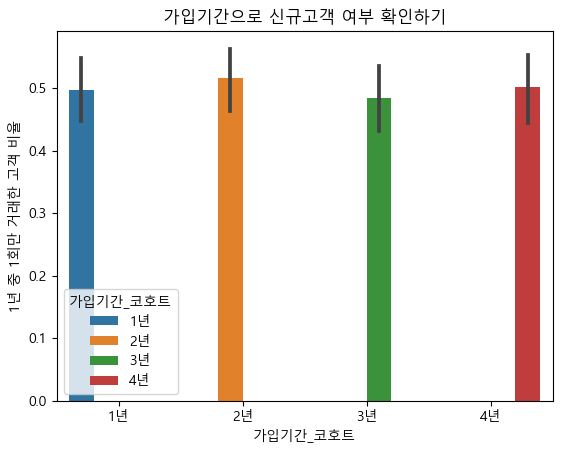

In [18]:
sns.barplot(data=onetime_customer, x='가입기간_코호트', y='Onetime', hue='가입기간_코호트')
plt.title('가입기간으로 신규고객 여부 확인하기')
plt.ylabel('1년 중 1회만 거래한 고객 비율')
plt.show()

✅ Data Insights.

1년 중 하루만 거래를 했다고 해서 가입기간이 적은 고객들이 많은 것은 아님.
- 주어진 데이터로만 이해했을 때, 상대적으로 가입기간이 낮은 편에 속하는 사람들이 4년 대비 1년이 12名 정도 더 많음.

하지만 이는 유의미하진 않기에 가입기간에 여부와 상관없이 1년 중에 1회만 Seasonality을 띄며 거래를 하는 고객들의 비중이 50%임을 알 수 있음.

## Onetime 고객이 아닌 사람들의 가입기간 여부 확인

In [19]:
rfm_df_not_onetime = onetime_customer[onetime_customer['Onetime'] == 0]
visual_not_onetime = rfm_df_not_onetime.groupby('Onetime')['가입기간_코호트'].value_counts()
visual_not_onetime

Onetime  가입기간_코호트
0        1년          190
         3년          185
         2년          184
         4년          175
Name: 가입기간_코호트, dtype: int64

✅ Data Insights.

- Onetime 고객이 아닌 사람들 역시 가입기간은 크게 유의미하진 않음

## onetime 고객 VS 나머지 고객 매출 비교

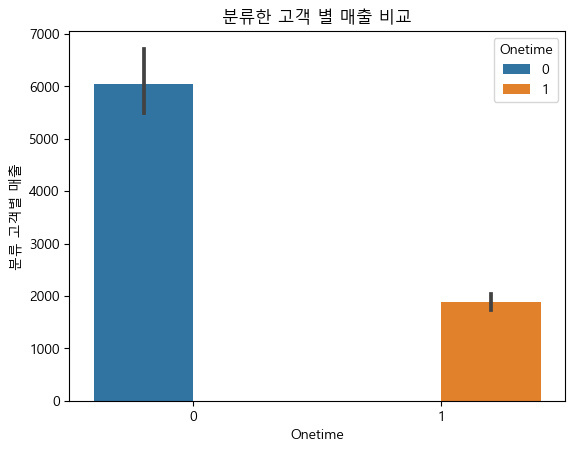

In [20]:
rfm_df_onetime = pd.merge(onetime_customer, rfm_df, on =['고객ID'])
sns.barplot(data=rfm_df_onetime, x='Onetime', y='매출', hue='Onetime')
plt.title('분류한 고객 별 매출 비교')
plt.ylabel('분류 고객별 매출')
plt.show()

✅ Data Insights.

- onetime 고객 : 총매출에 기여도가 낮은 편임을 확인할 수 있음. 이들을 따로 세그먼트 분석해줄 필요가 있음.

# RFM 분석. 지표별 분포 및 매출과의 관계 확인

In [21]:
# Onetime 고객들 newbi DataFrame으로 배제하기
newbi = rfm[rfm['Recency'] == 0]
condition_to_remove = (rfm['Recency'] == 0) 
# 전체고객에서 Onetime 고객 제외
rfm_old = rfm[~condition_to_remove]

In [22]:
newbi.head(5)

,고객ID,Monetary,Frequency,Recency,매출
3,USER_0345,1.24,1,0,9.1332
10,USER_0922,842.39,12,0,1024.9202
11,USER_1421,1830.27,13,0,2111.6174
12,USER_1249,544.02,7,0,657.7032
14,USER_0954,1965.43,14,0,2336.9806


In [23]:
newbi.describe()

,Monetary,Frequency,Recency,매출
count,734.000000,734.000000,734.0,734.000000
mean,1495.057929,17.565395,0.0,1876.445254
std,1761.493721,18.088473,0.0,2170.073846
min,1.000000,1.000000,0.0,7.700000
25%,301.882500,5.000000,0.0,397.176800
50%,912.665000,12.000000,0.0,1134.987000
75%,2073.210000,23.000000,0.0,2558.524800
max,11731.930000,118.000000,0.0,13826.830900


✅ Data Insights.

onetime 고객들의 RFM 통계량은 다음과 같음.
- Frequency (거래수) : 2019년 중 1번 거래하되, 평균 거래수 17.56회 구매 // 최소 1회 // 최대 118회 구매
- Monetary (주문금액): 2019년 중 1번 거래하되, 평균 구매 금액 1495.05달러 // 최소 1달러 // 최대 11731.93달러

In [24]:
rfm_old.head(5)

,고객ID,Monetary,Frequency,Recency,매출
0,USER_1358,34551.40,297,2,42112.3005
1,USER_0190,3048.79,44,139,3715.5339
2,USER_0066,2361.48,42,213,3523.2989
4,USER_0683,1043.72,6,16,1224.0684
5,USER_0730,904.04,35,26,1259.2621


In [25]:
rfm_old.describe()

,Monetary,Frequency,Recency,매출
count,734.000000,734.000000,734.000000,734.000000
mean,4868.422480,54.538147,65.660763,6052.463080
std,6523.752366,64.580337,71.390005,8071.949302
min,19.380000,2.000000,1.000000,36.357200
25%,1541.667500,19.000000,2.000000,1940.394550
50%,3115.400000,39.000000,41.000000,3941.009100
75%,6054.057500,67.000000,108.750000,7595.477750
max,75937.550000,695.000000,351.000000,93405.390200


✅ Data Insights.

onetime고객을 제외한 고객별 RFM 지표 통계량은 다음과 같다.

- Recency (최근구매주기): 평균 65일마다 구매 // 최소 1일 // 최대 351일만에 구매
- Frequency (거래수) : 평균 년간 36.05회 구매 // 최소 1회 // 최대 695회 구매
- Monetary (주문금액): 2019년 동안 평균 구매 금액 4868.42달러 // 최소 1달러 // 최대 75937.55달러

## Onetime 고객 제외 그룹 Recency 분포

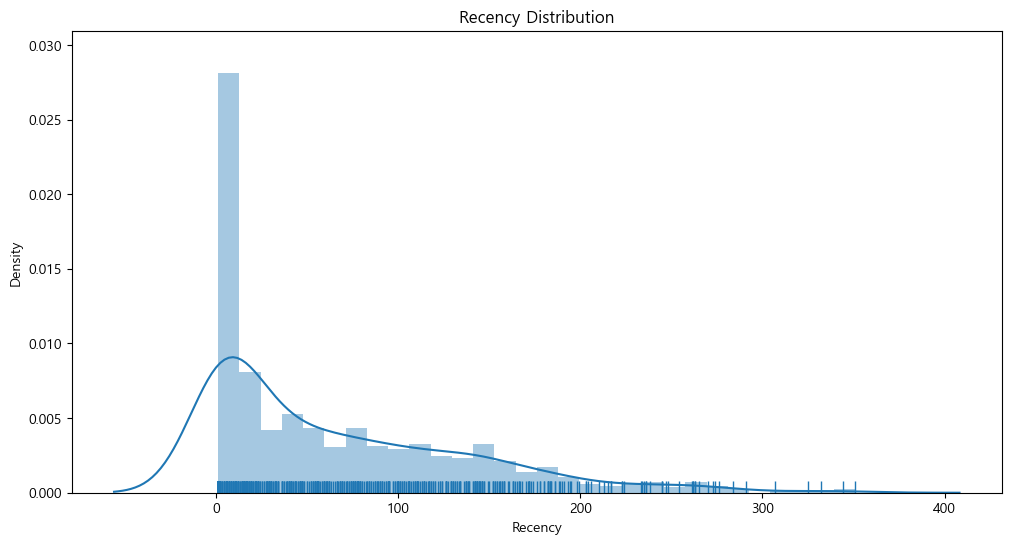

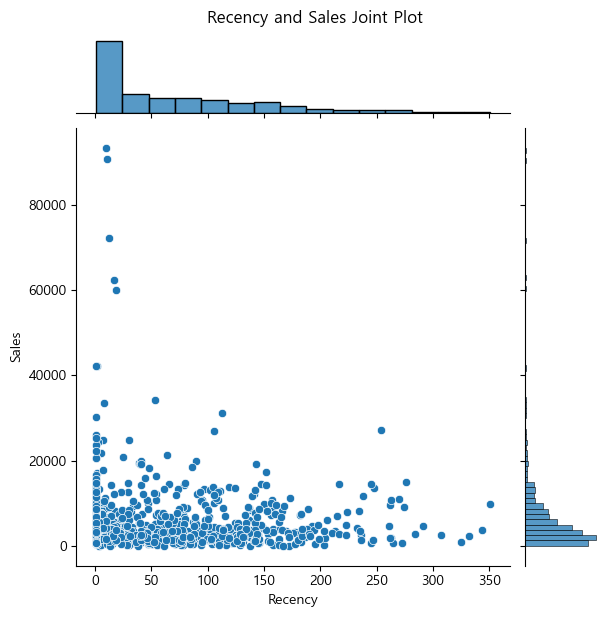

In [26]:
plt.figure(figsize=(12, 6))
sns.distplot(rfm_old['Recency'], kde=True, rug=True, bins=30,)
plt.title("Recency Distribution")
plt.show()
# 매출과의 연관관계
sns.jointplot(x="Recency", y="매출", data=rfm_old)
plt.suptitle("Recency and Sales Joint Plot", y=1.02)
plt.ylabel('Sales')
plt.show()

✅ Data Insights.

< Onetime고객 제외한 그룹의 Recency의 경우 >

- 매출과 음의 상관관계를 띄고 있는 것을 알 수 있음
- 즉, 최근구매주기가 짧을수록 매출에 긍정적인 영향을 준다는 점 확인 가능

## Onetime 고객 제외 그룹 Frequency 분포

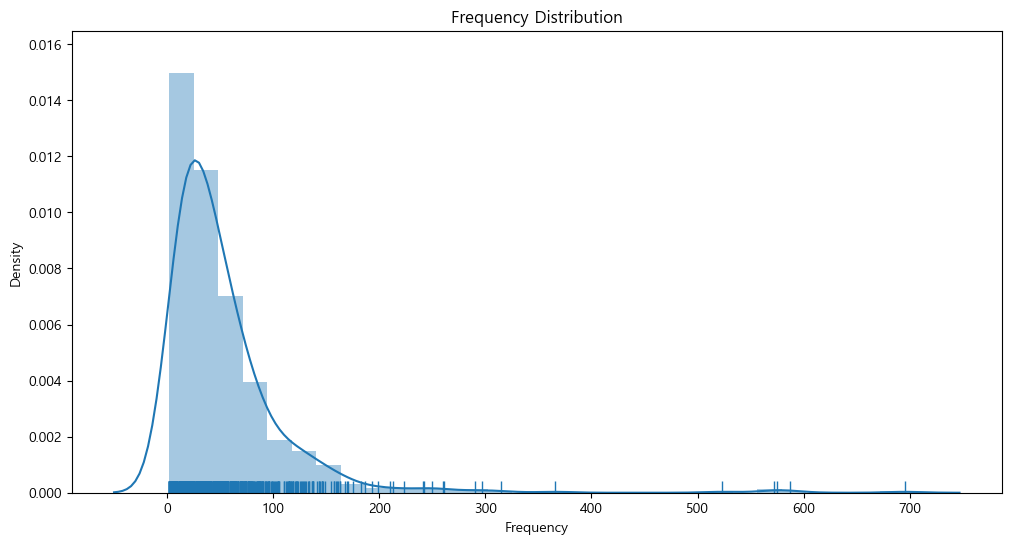

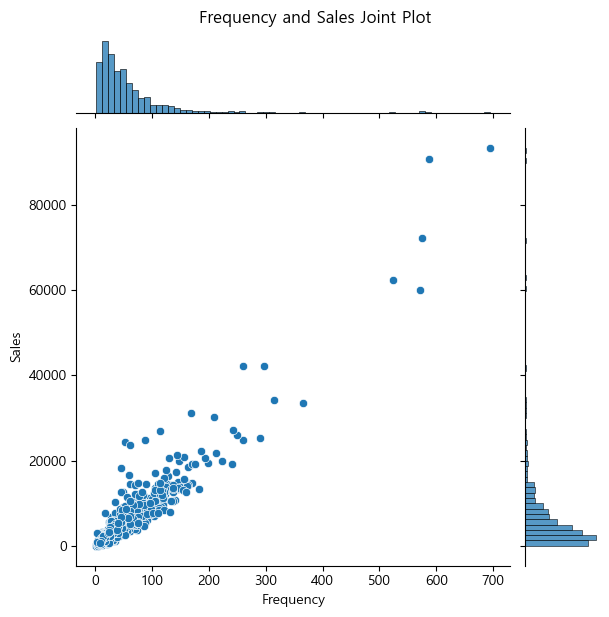

In [27]:
plt.figure(figsize=(12, 6))
sns.distplot(rfm_old['Frequency'], kde=True, rug=True, bins=30,)
plt.title("Frequency Distribution")
plt.show()

sns.jointplot(x="Frequency", y="매출", data=rfm_old)
plt.suptitle("Frequency and Sales Joint Plot", y=1.02)
plt.ylabel('Sales')
plt.show()

In [28]:
rfm_old['Frequency'].describe()

count    734.000000
mean      54.538147
std       64.580337
min        2.000000
25%       19.000000
50%       39.000000
75%       67.000000
max      695.000000
Name: Frequency, dtype: float64

✅ Data Insights

- Onetime 고객 제외한 그룹의 Frequency의 경우 
    - 4점, 5점 척도로 나누어서 볼 수 있음.
    - 매출과 양의 방향으로 선형 관계를 띄는 모습 확인할 수 있음

## Onetime 고객 제외 그룹 Monetary 분포

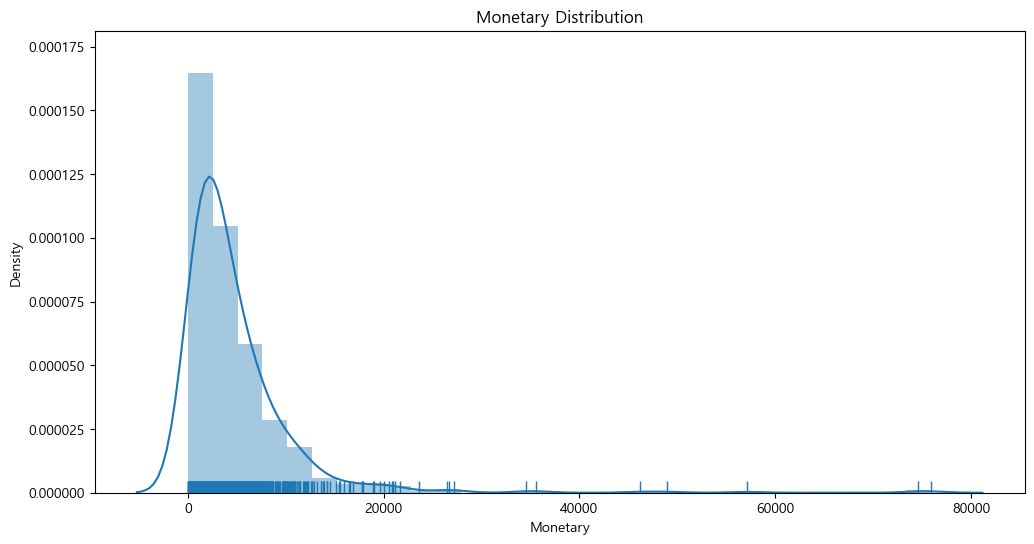

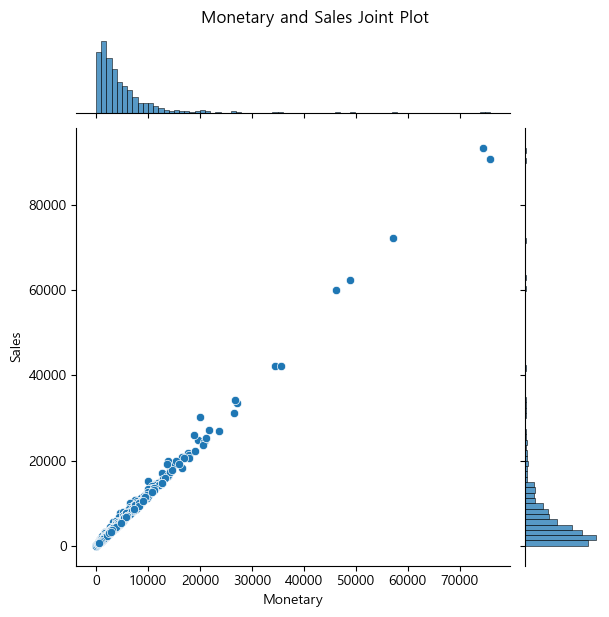

In [29]:
plt.figure(figsize=(12, 6))
sns.distplot(rfm_old['Monetary'], kde=True, rug=True, bins=30,)
plt.title("Monetary Distribution")
plt.show()

sns.jointplot(x="Monetary", y="매출", data=rfm_old)
plt.suptitle("Monetary and Sales Joint Plot", y=1.02)
plt.ylabel('Sales')
plt.show()

In [30]:
rfm_old['Monetary'].describe()

count      734.000000
mean      4868.422480
std       6523.752366
min         19.380000
25%       1541.667500
50%       3115.400000
75%       6054.057500
max      75937.550000
Name: Monetary, dtype: float64

✅ Data Insights

Onetime 고객 제외한 그룹의 Monetary의 경우
- 4점 또는 5점척도까지 나누어서 볼 수 있음.
- 매출과 양의 방향으로 선형 관계를 띄는 모습 확인할 수 있음

## Onetime 고객 Frequency 분포

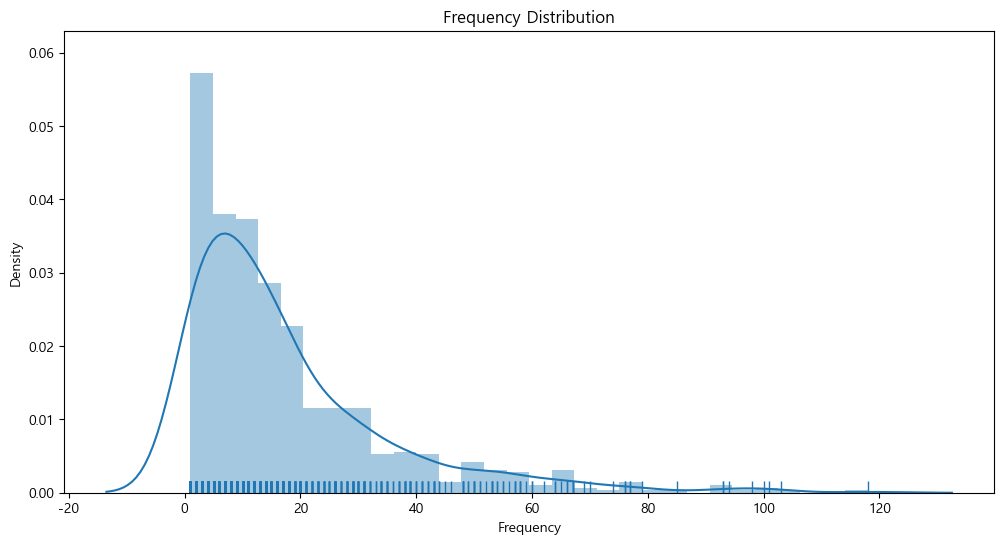

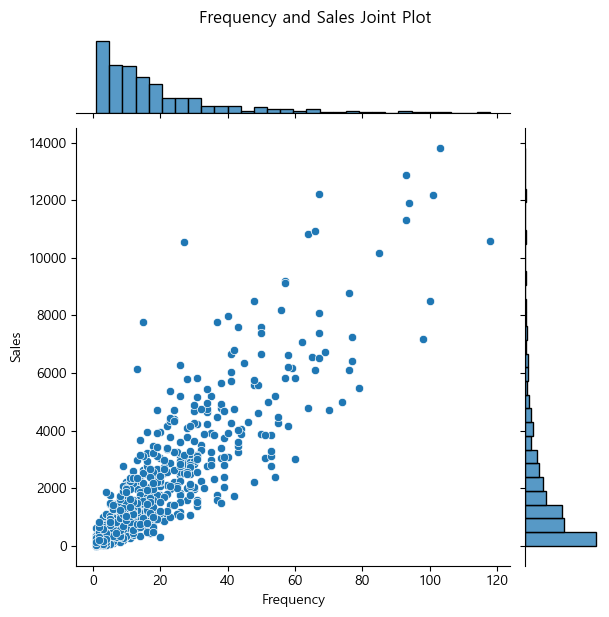

In [31]:
plt.figure(figsize=(12, 6))
sns.distplot(newbi['Frequency'], kde=True, rug=True, bins=30,)
plt.title("Frequency Distribution")
plt.show()

sns.jointplot(x="Frequency", y="매출", data=newbi)
plt.suptitle("Frequency and Sales Joint Plot", y=1.02)
plt.ylabel('Sales')
plt.show()

In [32]:
newbi['Frequency'].describe()

count    734.000000
mean      17.565395
std       18.088473
min        1.000000
25%        5.000000
50%       12.000000
75%       23.000000
max      118.000000
Name: Frequency, dtype: float64

✅ Data Insights


Onetime고객들의 Frequency의 경우
- 4, 5점척도로 나누어서 볼 수 있음.
- 매출과 양의 방향으로 선형 관계를 띄는 모습 확인할 수 있음

## Onetime 고객 Monetary 분포

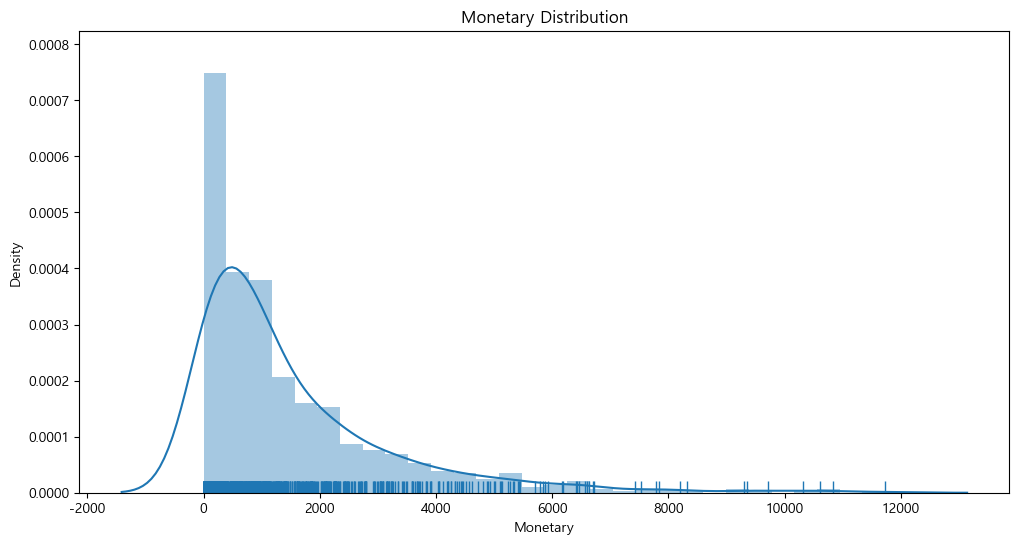

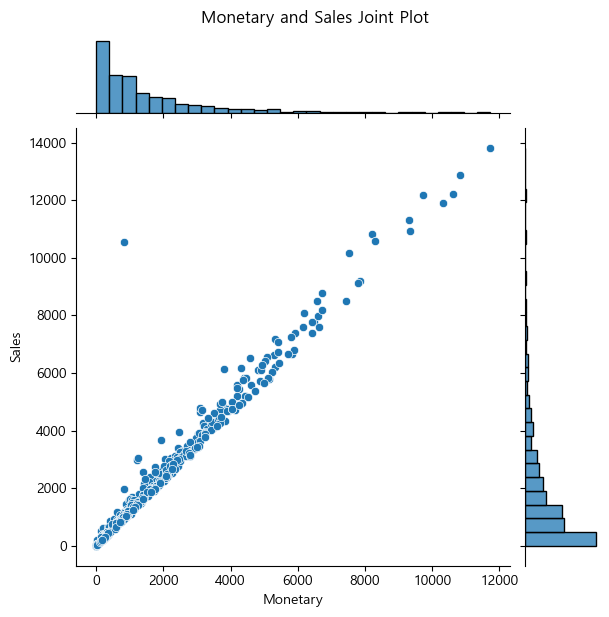

In [33]:
plt.figure(figsize=(12, 6))
sns.distplot(newbi['Monetary'], kde=True, rug=True, bins=30,)
plt.title("Monetary Distribution")
plt.show()

sns.jointplot(x="Monetary", y="매출", data=newbi)
plt.suptitle("Monetary and Sales Joint Plot", y=1.02)
plt.ylabel('Sales')
plt.show()

✅ Data Insights

Onetime고객들의 Monetary의 경우

- 4, 5점척도로 나누어서 볼 수 있음.
- 매출과 양의 방향으로 선형 관계를 띄는 모습 확인할 수 있음
- 이상치 발견해 해당 고객의 매출이 높게 나온 원인 확인 必

### 이상치 이유

In [34]:
print(newbi[(newbi['매출'] >= 10000) & (newbi['Monetary'] <= 2000)]['고객ID'])
online[online['고객ID'] == 'USER_0161']['배송료']

1247    USER_0161
Name: 고객ID, dtype: object


42400     12.99
42401     12.99
42402    324.00
42403    324.00
42404    324.00
42405    324.00
42406    324.00
42407    324.00
42408    324.00
42409    324.00
42410    324.00
42411    324.00
42412    324.00
42413    324.00
42414    324.00
42415    324.00
42416    324.00
42417    324.00
42418    324.00
42419    324.00
42420    324.00
42421    324.00
42422    324.00
42423    324.00
42424    324.00
42425    324.00
42426    324.00
Name: 배송료, dtype: float64

✅ Data Insights

- 고객ID가 USER_0161인 사람의 경우 배송료가 매우 비싸게 나온 것 확인할 수 있음.

# RFM Score 산정

## Onetime 고객 제외 Score

In [35]:
colasd = ['Recency', 'Frequency', 'Monetary']
quantiles = [20, 40, 60, 80, 100]
for col in rfm_old[colasd]:
    print(f"{col} 컬럼의 분위수 값:")
    for q in quantiles:
        quantile_value = np.percentile(rfm_old[col], q)
        print(f"{q}%: {quantile_value}")
    print()

Recency 컬럼의 분위수 값:
20%: 1.0
40%: 21.0
60%: 65.80000000000001
80%: 126.39999999999998
100%: 351.0

Frequency 컬럼의 분위수 값:
20%: 17.0
40%: 29.19999999999999
60%: 48.0
80%: 76.0
100%: 695.0

Monetary 컬럼의 분위수 값:
20%: 1285.2359999999999
40%: 2415.432
60%: 4043.2560000000003
80%: 6936.279999999999
100%: 75937.55



✅ Data Insights

- Recency의 경우 기준값을 직접 잡는 것이 좋아보임.
- Frequency의 경우 4분위수를 따라 진행
- Monetary의 경우 4분위수를 따라 진행

In [36]:
# level 내 배열 기준으로 1점부터 len(level) + 1까지 점수 부여
def get_score(level, df):
    score = []
    for i in range(len(df)):
        for j in range(len(level)):
            if df[i] <= level[j]:
                score.append(j+1)
                break
            elif df[i] > max(level):
                score.append(len(level)+1)
                break
            else:
                continue
    return score

def get_recency_score(level, df):
    score = []
    for i in range(len(df)):
        for j in range(len(level)):
            if df[i] >= level[j]:  # 값이 클수록 높은 점수를 주도록 부등호를 변경합니다.
                score.append(len(level) - j)  # 점수가 큰 순서대로 부여되도록 len(level)에서 j를 뺍니다.
                break
            elif df[i] < min(level):  # 가장 작은 레벨보다 값이 작으면 가장 높은 점수를 부여합니다.
                score.append(len(level) + 1)
                break
            else:
                continue
    return score

# 고객 별 Recency, Frequency, Monetary 주어졌을 때 이를 분위수를 기준으로 점수화한 것.
def get_rfm_grade(df, num_class, rfm_tick_point, rfm_col_map, suffix=None):
    from sklearn import preprocessing
    
    for k, v in rfm_tick_point.items():
        if isinstance(v, str):
            if v == 'quantile':
                # 데이터 스케일링
                scale = preprocessing.StandardScaler()
                tmp_data = np.array(df[rfm_col_map[k]])
                tmp_data = tmp_data.reshape((-1, 1))
                tmp_data = scale.fit_transform(tmp_data)
                tmp_data = tmp_data.squeeze()
                
                # 분위수
                quantile_level = np.linspace(0, 1, num_class+1)[1:-1]
                quantile = []
                for q in quantile_level:
                    quantile.append(np.quantile(tmp_data, q))
            else:
                tmp_data = np.array(df[rfm_col_map[k]])    
                quantile = np.linspace(np.min(tmp_data), np.max(tmp_data), num_class+1)[1:-1]
        else:
            tmp_data = np.array(df[rfm_col_map[k]])
            quantile = v
            
        if k == 'F' or 'M':
            score = get_score(quantile, tmp_data)
            new_col_name = rfm_col_map[k] + '_' +k
        elif k == 'R':
            score = get_recency_score(quantile, tmp_data)
            new_col_name = rfm_col_map[k] + '_' +k
        if suffix:
            new_col_name = rfm_col_map[k]+'_'+suffix
        df[new_col_name] = score
    return df

rfm_tick_point={'R':'quantile','F':'quantile','M':'quantile'}
rfm_col_map={'R':'Recency','F':'Frequency','M':'Monetary'}

rfm_old = get_rfm_grade(df=rfm_old, num_class=5, rfm_tick_point=rfm_tick_point, rfm_col_map=rfm_col_map)

bins = [0, 1, 21, 65.81, 126.4, 352]  
labels = [5, 4, 3, 2, 1]
rfm_old['Recency_Bin'] = pd.cut(rfm_old['Recency'], bins=bins, labels=labels, right=False)
rfm_old.loc[rfm_old['Recency'] == 1, 'Recency_Bin'] = 5
rfm_old.rename(columns = {'Recency_Bin':'R', 'Frequency_F':'F', 'Monetary_M':'M'}, inplace=True)
rfm_old = rfm_old.drop(['Recency_R'],axis=1)
rfm_old['R'] = rfm_old['R'].astype('int')

In [37]:
rfm_old.head(3)

,고객ID,Monetary,Frequency,Recency,매출,F,M,R
0,USER_1358,34551.40,297,2,42112.3005,5,5,4
1,USER_0190,3048.79,44,139,3715.5339,3,3,1
2,USER_0066,2361.48,42,213,3523.2989,3,2,1


< Onetime고객 제외 그룹 RFM 점수 분포 >


| 점수| Recency     | Frequency (거래수)   | Monetary (구매금액)|
|-----|-------------|----------------------|--------------------|
| 5점 | 1일   | 77회 ~ 695회| 6967.63 ~ 75937.55 |
| 4점 | 2일 ~ 20일   | 49회 ~ 76회 | 4045.21 ~ 6915.38 |
| 3점 | 21일 ~ 65일 | 30회 ~ 48회 | 2422.28 ~ 4035.44 |
| 2점 | 66일 ~ 126일  | 18회 ~ 30회  | 1286.34 ~ 2413.72 |
| 1점 | 127일 ~ 351일   | 2회 ~ 17회   | 19.38 ~ 1283.58 |


## Onetime 고객들 FM Score 산정

In [38]:
newbi = get_rfm_grade(df=newbi, num_class=5, rfm_tick_point=rfm_tick_point, rfm_col_map=rfm_col_map)
newbi.drop(['Recency', 'Recency_R'], axis=1, inplace=True)
newbi.rename(columns = {'Frequency_F':'F', 'Monetary_M':'M'}, inplace=True)
newbi.head(4)

,고객ID,Monetary,Frequency,매출,F,M
3,USER_0345,1.24,1,9.1332,1,1
10,USER_0922,842.39,12,1024.9202,3,3
11,USER_1421,1830.27,13,2111.6174,3,4
12,USER_1249,544.02,7,657.7032,2,2


< Onetime고객 그룹 FM 점수 분포 >


| 점수| Frequency (거래수)   | Monetary (구매금액)|
|-----|----------------------|--------------------|
| 5점 | 29회 ~ 118회| 2353.71 ~ 11731.93 |
| 4점 | 17회 ~ 28회 | 1203.76 ~ 2353.19 |
| 3점 | 10회 ~ 16회 | 653.66 ~ 1196.22 |
| 2점 | 5회 ~ 9회  | 216.4 ~ 652.82 |
| 1점 | 1회 ~ 4회   | 1 ~ 213.36 |


## 산정한 Score 기반으로 RFM Segment 진행

In [39]:
## Onetime고객 제외 그룹
rfm_old["RFM_segment"] = rfm_old['R'].astype(str) + rfm_old['F'].astype(str) + rfm_old['M'].astype(str)
rfm_old["RFM_score"] = rfm_old[['R', 'F', 'M']].sum(axis = 1)
rfm_old = rfm_old[['고객ID', 'Recency', 'Frequency', 'Monetary', 'R', 'F', 'M', '매출', 'RFM_segment', 'RFM_score']]
rfm_old.head(5)

,고객ID,Recency,Frequency,Monetary,R,F,M,매출,RFM_segment,RFM_score
0,USER_1358,2,297,34551.40,4,5,5,42112.3005,455,14
1,USER_0190,139,44,3048.79,1,3,3,3715.5339,133,7
2,USER_0066,213,42,2361.48,1,3,2,3523.2989,132,6
4,USER_0683,16,6,1043.72,4,1,1,1224.0684,411,6
5,USER_0730,26,35,904.04,3,3,1,1259.2621,331,7


In [40]:
## Onetime고객 그룹
newbi["FM_segment"] = newbi['F'].astype(str) + newbi['M'].astype(str)
newbi["FM_score"] = newbi[['F', 'M']].sum(axis = 1)
newbi = newbi[['고객ID', 'Frequency', 'Monetary', 'F', 'M', '매출', 'FM_segment', 'FM_score']]
newbi.head(5)

,고객ID,Frequency,Monetary,F,M,매출,FM_segment,FM_score
3,USER_0345,1,1.24,1,1,9.1332,11,2
10,USER_0922,12,842.39,3,3,1024.9202,33,6
11,USER_1421,13,1830.27,3,4,2111.6174,34,7
12,USER_1249,7,544.02,2,2,657.7032,22,4
14,USER_0954,14,1965.43,3,4,2336.9806,34,7


## Segment 별 구간 확인

### Onetime 고객 제외 그룹

array([[<Axes: title={'center': 'Recency'}>,
        <Axes: title={'center': 'Frequency'}>],
       [<Axes: title={'center': 'Monetary'}>,
        <Axes: title={'center': 'R'}>],
       [<Axes: title={'center': 'F'}>, <Axes: title={'center': 'M'}>]],
      dtype=object)

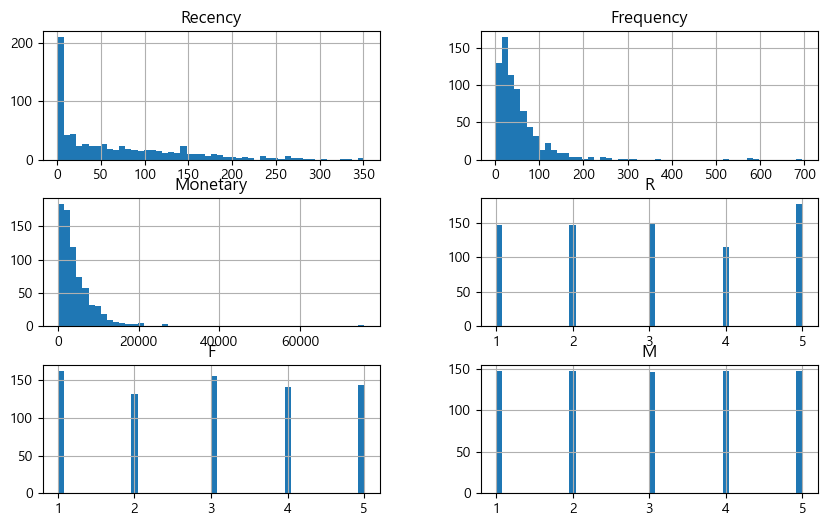

In [41]:
rfm_old.iloc[:, 1:-3].astype(float).hist(figsize = (10, 6), bins = 50)

### Onetime 고객 그룹

array([[<Axes: title={'center': 'Frequency'}>,
        <Axes: title={'center': 'Monetary'}>],
       [<Axes: title={'center': 'F'}>, <Axes: title={'center': 'M'}>]],
      dtype=object)

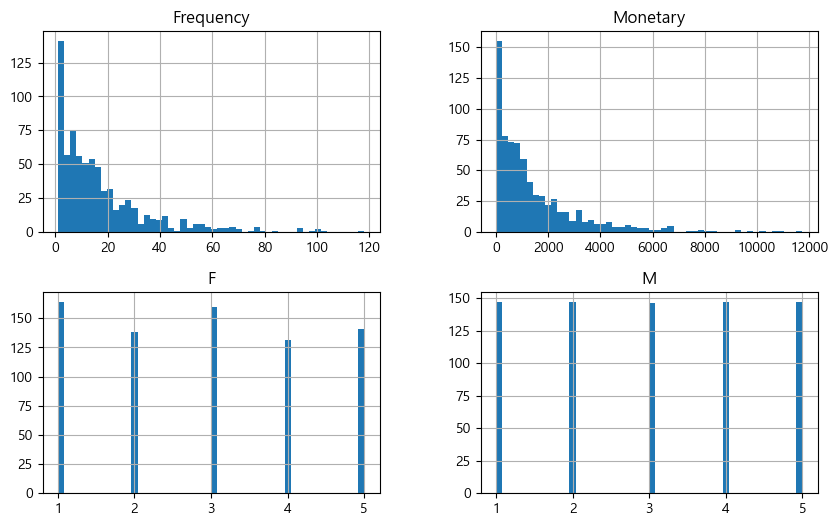

In [42]:
newbi.iloc[:, 1:-3].astype(float).hist(figsize = (10, 6), bins = 50)

✅ Data Insights

구간화 정상적으로 분류된 점 확인가능

## Score 분포 확인

### Onetime 고객 제외 그룹

<Axes: title={'center': 'Onetime 고객 제외 그룹'}, xlabel='RFM_segment', ylabel='RFM_score'>

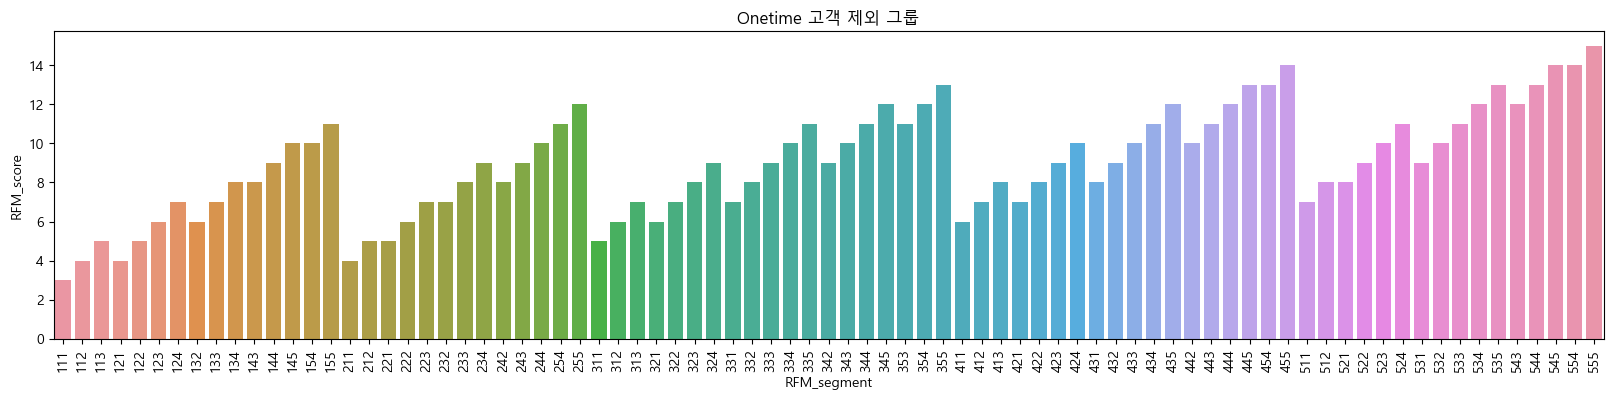

In [43]:
plt.figure(figsize=(20, 4))
plt.xticks(rotation=90)
plt.title('Onetime 고객 제외 그룹')
sns.barplot(data = rfm_old.sort_values('RFM_segment'), x = 'RFM_segment', y = 'RFM_score')

In [44]:
rfm_old.groupby('RFM_score').agg({"Recency": "mean", 
                              "Frequency": "mean",
                              "Monetary": ['mean', 'sum']}).style.format('{:,.0f}').background_gradient()

✅ Data Insights

< Onetime고객 제외 그룹 >

RFM 각각의 구간화 및 분포는 앞서 찍은 시각화를 통해 통계적으로 유의하게 나뉜 것 확인 가능.

이에 따른 합산한 RFM_score의 분포는 위와 같음.

- score가 커질수록 Recency (최근구매주기)는 낮아지고, Frequency, Monetary가 가파르게 상승하는 점 확인 가능.
- score가 11이상인 경우, 특이하게 Recency는 높으나 거래한 횟수, 매출의 평균은 상당히 높게 측정됌.

- score가 15인 경우 보다 14인 경우의 매출이 더 높게 측정됌. (2일 동안 짧게 구매한 케이스가 많은 점 확인 가능)


### Onetime 고객 그룹

<Axes: title={'center': 'Onetime고객 그룹'}, xlabel='FM_segment', ylabel='FM_score'>

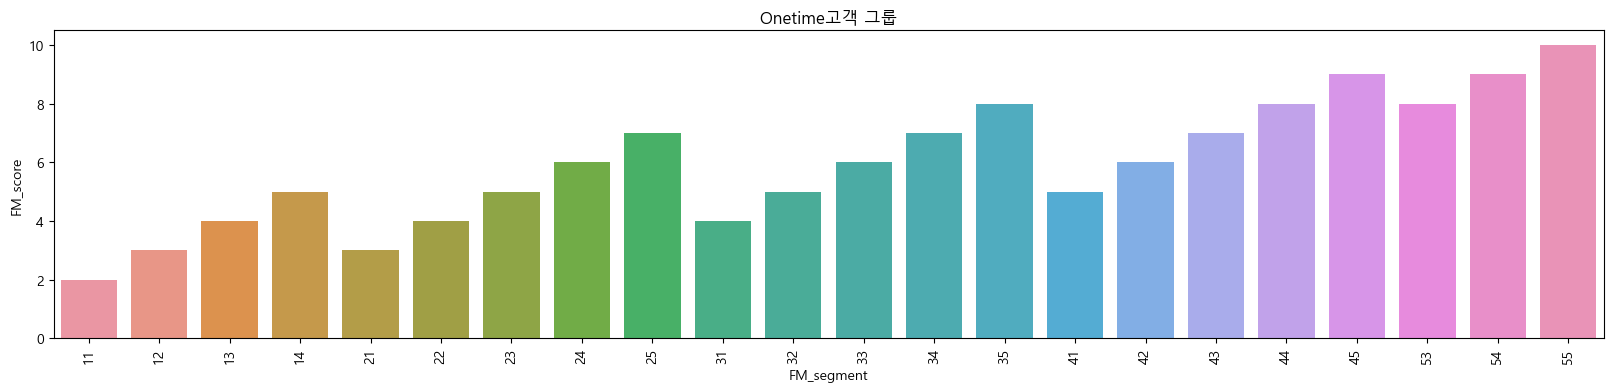

In [45]:
plt.figure(figsize=(20, 4))
plt.xticks(rotation=90)
plt.title('Onetime고객 그룹')
sns.barplot(data = newbi.sort_values('FM_segment'), x = 'FM_segment', y = 'FM_score')

In [46]:
newbi.groupby('FM_score').agg({"Frequency": "mean",
                              "Monetary": ['mean', 'sum']}).style.format('{:,.0f}').background_gradient()

✅ Data Insights

< Onetime고객 그룹 : 2019년 중 하루만 거래를 한 사람들 > 의 정보를 파악하면 다음과 같다.

스코어가 높을수록 거래 횟수, 구매한 금액의 평균이 높은 점 확인 가능

# Segment 지정

## Onetime 고객 제외 그룹

GOLD      145
FAMILY    135
SILVER    133
MEMBER    131
VIP       126
VVIP       64
Name: RFM_class, dtype: int64


<Axes: xlabel='RFM_class', ylabel='RFM_score'>

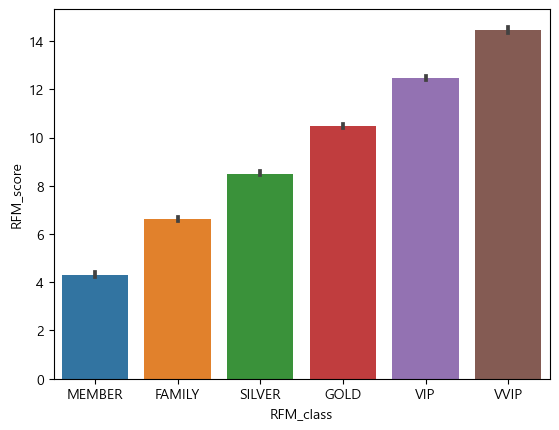

In [47]:
labels = ['MEMBER', 'FAMILY', 'SILVER', 'GOLD', 'VIP', 'VVIP']
rfm_old['RFM_class'] = pd.qcut(rfm_old['RFM_score'], 6, labels)
print(rfm_old['RFM_class'].value_counts())
sns.barplot(data=rfm_old, x="RFM_class", y="RFM_score")

<Axes: xlabel='RFM_class', ylabel='RFM_score'>

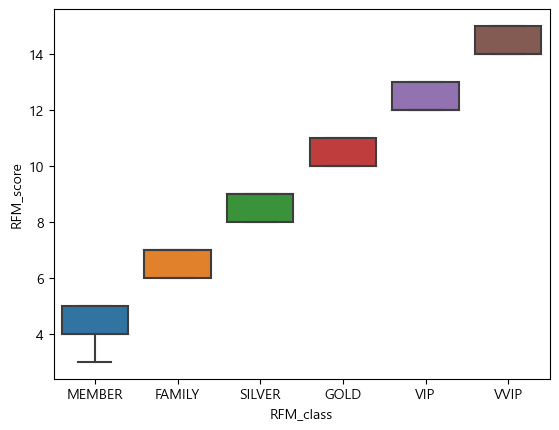

In [48]:
sns.boxplot(data=rfm_old, x="RFM_class", y="RFM_score")

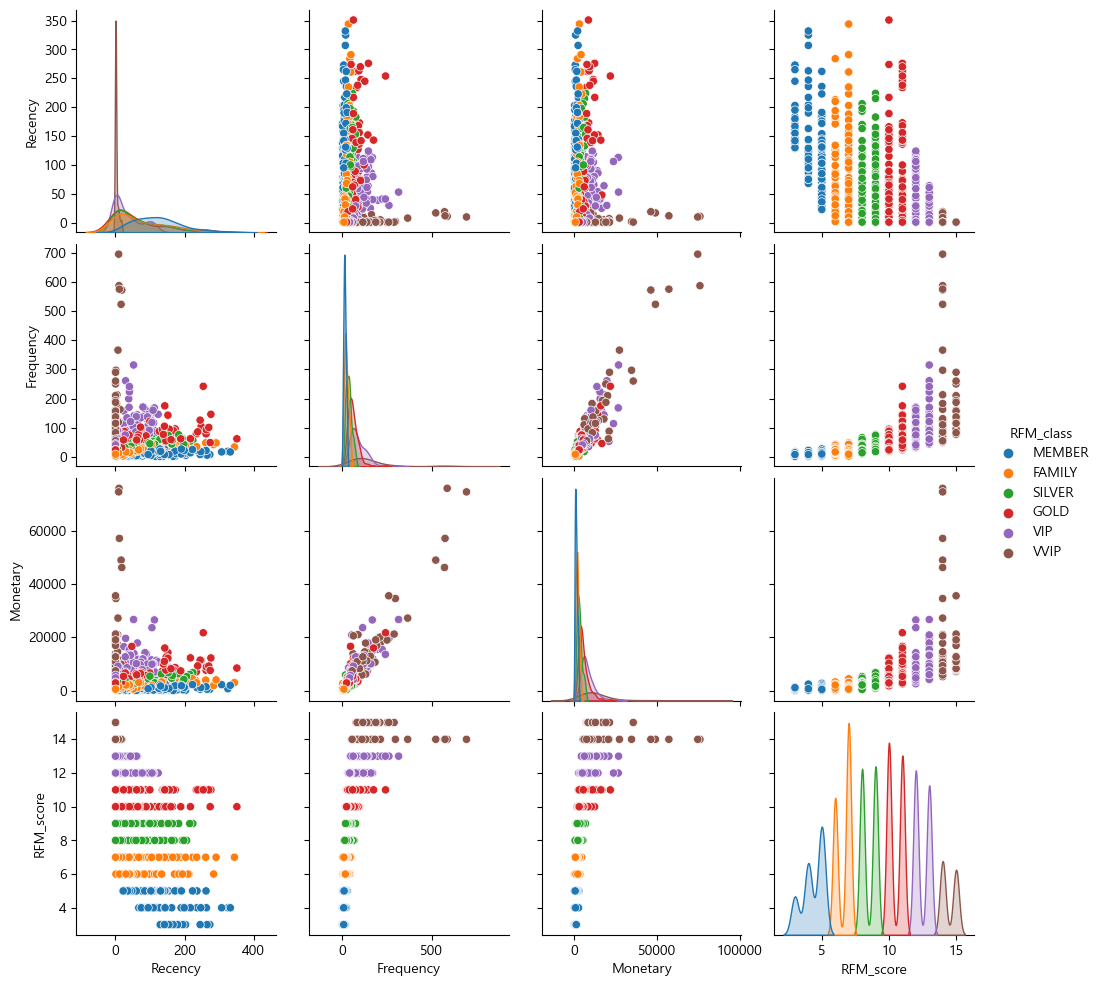

In [49]:
sns.pairplot(data = rfm_old[['Recency', 'Frequency', 'Monetary', 'RFM_class', 'RFM_score']], hue = 'RFM_class')

<Axes: >

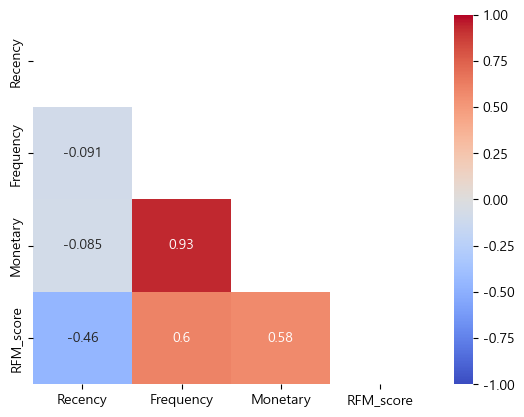

In [50]:
corr = rfm_old[['Recency', 'Frequency', 'Monetary', 'RFM_score']].corr()
mask = np.triu(np.ones_like(corr))
sns.heatmap(corr, cmap = 'coolwarm', vmin = -1, vmax = 1, annot = True, mask = mask)

## Onetime 고객 그룹

In [51]:
newbi.groupby('FM_score').agg({"Frequency": "mean",
                              "Monetary": ['mean', 'sum']}).style.format('{:,.0f}').background_gradient()

ONETIME    734
Name: FM_class, dtype: int64


<Axes: xlabel='FM_class', ylabel='FM_score'>

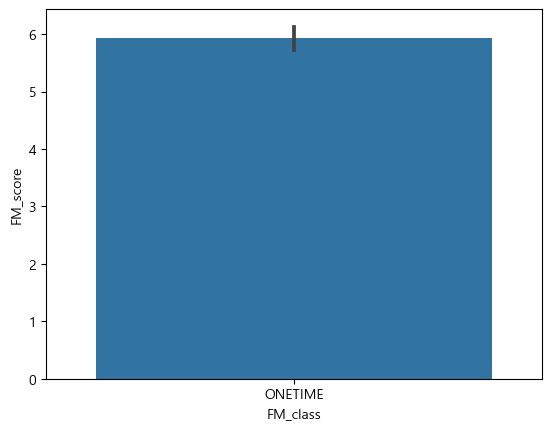

In [52]:
labels = ['ONETIME']
newbi['FM_class'] = pd.qcut(newbi['FM_score'], 1, labels)
print(newbi['FM_class'].value_counts())
sns.barplot(data=newbi, x="FM_class", y="FM_score")

<Axes: xlabel='FM_class', ylabel='FM_score'>

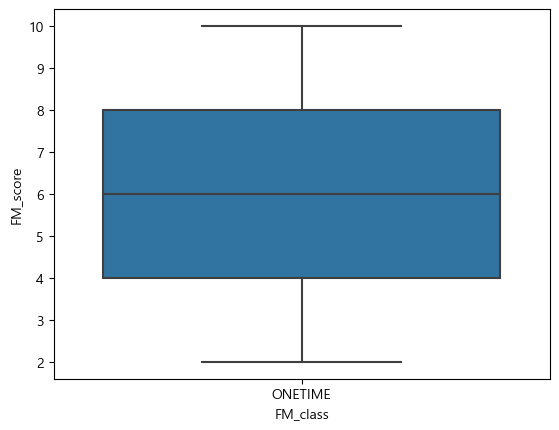

In [53]:
sns.boxplot(data=newbi, x="FM_class", y="FM_score")

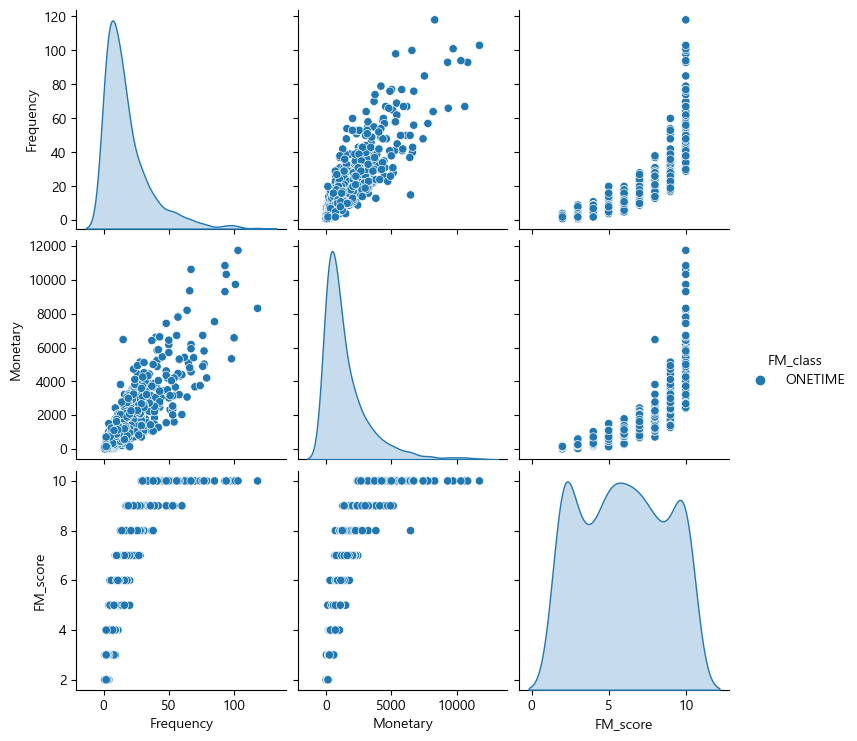

In [54]:
sns.pairplot(data = newbi[['Frequency', 'Monetary', 'FM_class', 'FM_score']], hue = 'FM_class')

<Axes: >

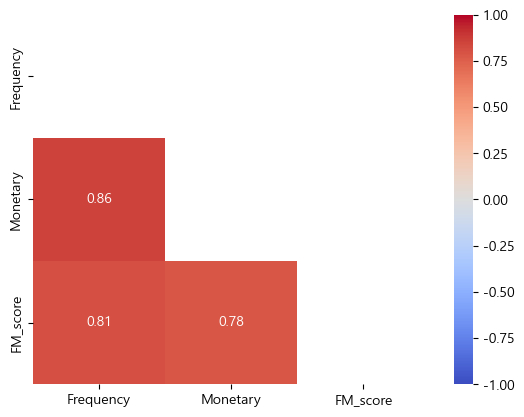

In [55]:
corr = newbi[['Frequency', 'Monetary', 'FM_score']].corr()
mask = np.triu(np.ones_like(corr))
sns.heatmap(corr, cmap = 'coolwarm', vmin = -1, vmax = 1, annot = True, mask = mask)

# 데이터 병합 후 고객등급별 인당 매출 확인 
-> 등급 분류 잘 되었나 확인하는 과정

In [56]:
newbi['Recency'] = 0
newbi['R'] = 0
newbi.rename(columns = {'FM_segment':'RFM_segment', 'FM_score':'RFM_score', 'FM_class':'RFM_class'}, inplace=True)
newbi = newbi[['고객ID', 'Recency', 'Frequency', 'Monetary', 'R','F','M','매출','RFM_segment', 'RFM_score','RFM_class']]
df = pd.concat([newbi, rfm_old])
df.rename(columns = {'매출':'개인총매출'},inplace=True)

In [57]:
df_merge = df[['고객ID', 'R','F','M', 'RFM_segment', 'RFM_score', '개인총매출', 'RFM_class']]
final_df = pd.merge(df, online, on=['고객ID'], how='right')

In [58]:
final_df.columns

Index(['고객ID', 'Recency', 'Frequency', 'Monetary', 'R', 'F', 'M', '개인총매출',
       'RFM_segment', 'RFM_score', 'RFM_class', '거래ID', '제품ID', '제품카테고리', '수량',
       '평균금액', '배송료', '쿠폰상태', 'Weekday', '연', '월', '일', '쿠폰코드', '할인율', 'GST',
       '성별', '고객지역', '가입기간', '가입기간_코호트', '오프라인비용', '온라인비용', '거래날짜', '주문금액',
       '할인금액', '매출', '영업이익'],
      dtype='object')

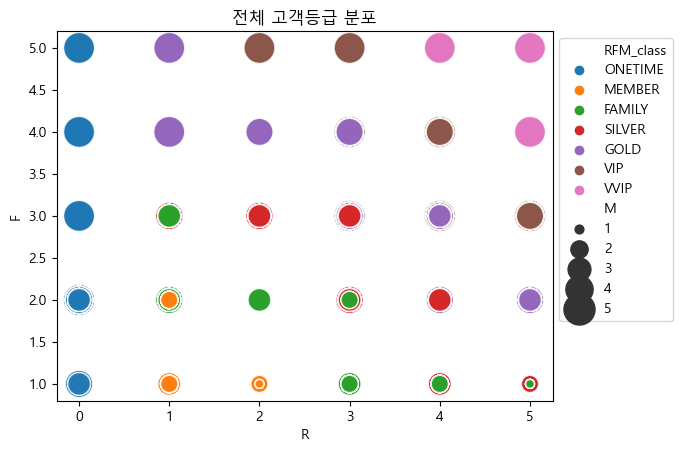

In [59]:
sns.scatterplot(x = final_df['R'], y = final_df['F'], alpha = 0.8
                ,size = final_df['M'], sizes = (40,500)
                ,hue = final_df['RFM_class'], hue_order = ['ONETIME', 'MEMBER', 'FAMILY', 'SILVER', 'GOLD', 'VIP', 'VVIP']
               )
plt.legend(loc = 'upper left', bbox_to_anchor=(1, 1))
plt.title('전체 고객등급 분포')
plt.show()

✅ Data Insights

- R이 5점이어도 1년 간 구매횟수 F가 낮고 최근구매주기가 짧아도 FAMILY로 등급이 낮고,
- R이 5점이되, 1년 간 구매횟수인 F 빈도수가 잦을수록 등급이 올라가도록 설정.

In [60]:
# 등급별 고객수 확인
df_class = df['RFM_class'].value_counts()
cust_count = pd.DataFrame(df_class)
cust_count.reset_index(drop=False,inplace=True)
cust_count.rename(columns={'RFM_class':'고객수' ,'index':'RFM_class'},inplace=True)

# 등급별 총매출, 평균매출금액 확인
sales_check = final_df.groupby('RFM_class')['매출', '주문금액'].sum().reset_index()
mean_sales_check = final_df.groupby('RFM_class')['주문금액'].mean().reset_index()
mean_sales_check.rename(columns={'주문금액':'평균주문금액'}, inplace=True)

# 병합 후 등급별 인당매출 비교
membership = pd.merge(cust_count, sales_check, on=['RFM_class']).merge(mean_sales_check, on=['RFM_class'])
membership['인당 매출'] = membership['매출'] / membership['고객수']
membership['매출 비중'] = membership['매출'] / sum(membership['매출'])
membership.sort_values(by=['인당 매출'], ascending=False)

,RFM_class,고객수,매출,주문금액,평균주문금액,인당 매출,매출 비중
6,VVIP,64,1.247443e+06,1003683.67,97.237325,19491.289066,0.214344
5,VIP,126,1.278638e+06,1029649.05,89.698497,10147.919444,0.219704
1,GOLD,145,9.637100e+05,780834.65,90.479102,6646.276124,0.165591
3,SILVER,133,4.957089e+05,395721.72,82.304850,3727.134386,0.085176
2,FAMILY,135,2.929659e+05,235428.50,77.956457,2170.117790,0.050339
0,ONETIME,734,1.377311e+06,1097372.52,85.113823,1876.445254,0.236659
4,MEMBER,131,1.640427e+05,128104.51,72.293742,1252.234637,0.028187


컬럼 설명

- RFM_class : 고객 등급
- 고객수 : 고객 등급별 고객수
- 매출 : 고객등급별 매출
- 주문금액 : 고객등급별 총주문금액 (상품수량 * 상품가격)
- 평균주문금액 : 고객등급별 평균주문금액 (등급별 총주문금액 / 거래 건수)
- 인당매출 : 고객등급별 매출 / 고객수

✅ Data Insights

앞서 데이터 분포에 맞게 RFM 등급을 산정한 대로 등급별 인당 기여한 매출이 잘 나온 모습.

- VVIP : 2019년 기준 빈도수, 구매한 총 금액이 가장 높은 고객들. 또한, 최근 구매한 주기가 짧은 그룹 (평균 RFM 점수 14.4)
- VIP : 2019년 기준 빈도수, 구매한 총 금액이 VVIP에는 못미치는 고객들, 또한 최근 구매한 주기가 상대적으로 짧은 그룹 (평균 RFM : 12.5)
- GOLD : 평균 10.56으로 VIP보단 전체적으로 낮은 수치로 2019년 인당 평균 6646달러 소비
- SILVER : 평균 8.58로 2019년 인당 평균 3727달러 소비
- FAMILY : 평균 6.63으로 2019년 인당 평균 2170달러 소비
- ONETIME : 평균 FM 기준 스코어는 8.18로 패밀리보단 높지만 평균 1876달러 소비
- MEMBER : 평균 4.46점으로 가장 낮으며 평균 1252달러 소비. 

따라서, 산정한 고객별 등급을 기준으로 코호트 분석 진행 이후 솔루션 제안하기.

(매출 비중이 높은 VVIP, VIP, GOLD 기준으로 고객 특성 파악하기)

# 고객등급 기반 코호트 분석 이전 이커머스 파악하기.

## 월별 고객 단위 지표

In [61]:
# 월별 고객 단위 매출, 영업이익 집계
month_customer_profit = online.groupby(['월', '고객ID'])[['매출', '영업이익']].sum().reset_index()
# 월별 고객 단위 거래수 확인
month_count = online.groupby(['월', '고객ID']).size().reset_index(name='거래수')
# 월별 고객 단위 평균주문금액 확인
month_mean_customer_order = online.groupby(['월', '고객ID'])[['주문금액']].mean().reset_index()
month_mean_customer_order.rename(columns = {'주문금액':'평균주문금액'}, inplace=True)

# 월별 고객 단위 데이터프레임
month_customer_df = pd.merge(month_customer_profit,month_count,on=['월', '고객ID']).merge(month_mean_customer_order,on=['월', '고객ID'])
customer_to_merge = customer[['고객ID', '성별','고객지역','가입기간_코호트']]
month_customer_df = pd.merge(customer_to_merge,month_customer_df,on =['고객ID'], how='right')

## 월별 단위 지표

In [62]:
# 월별 매출, 영업이익 집계
month_profit = online.groupby(['월'])[['매출', '영업이익']].sum().reset_index()
# 월별 전체 고객들의 평균거래수 확인
month_mean_count = month_count.groupby('월')['거래수'].mean().reset_index(name='전체고객_평균거래수')
# 월별 전체 고객들의 총거래수 확인
month_total_count = month_customer_df.groupby('월')['거래수'].sum().reset_index(name='월별_총거래수')
# 월별 전체 고객들의 평균주문금액 확인
month_mean_order = online.groupby('월')['주문금액'].mean().reset_index(name='전체고객_평균주문금액')
# 월별 온/오프라인 마케팅 비용 집계
month_marketing = marketing_df.groupby('월')['오프라인비용', '온라인비용'].sum().reset_index()

# 월별 지표 집계 데이터프레임
month_df = pd.merge(month_profit,month_mean_count,on=['월']).merge(month_total_count,on=['월']).merge(month_mean_order,on=['월']).merge(month_marketing,on=['월'])

# 월별 순이익 계산
month_df['순이익'] = month_df['영업이익'] - month_df['온라인비용'] - month_df['오프라인비용']
month_df['순이익 (%)'] = month_df['순이익'] / sum(month_df['순이익'])

In [63]:
month_df

,월,매출,영업이익,전체고객_평균거래수,월별_총거래수,전체고객_평균주문금액,오프라인비용,온라인비용,순이익,순이익 (%)
0,1,516548.7631,449895.080,18.897674,4063,99.341516,96600,58328.95,294966.130,0.092666
1,2,403972.3654,340613.066,30.128440,3284,94.646711,81300,55807.92,203505.146,0.063933
2,3,461898.5480,376441.466,20.894231,4346,80.443647,73500,48750.09,254191.376,0.079856
3,4,498426.7004,429659.757,18.526786,4150,96.775523,96000,61026.83,272632.927,0.085650
4,5,392711.0170,330270.284,22.860000,4572,67.314834,65500,52759.64,212010.644,0.066605
5,6,402421.9278,326425.795,16.189189,4193,76.575574,80500,53818.14,192107.655,0.060352
6,7,472264.0543,409349.716,22.250000,5251,70.965163,67500,52717.85,289131.866,0.090833
7,8,515852.1439,434199.774,20.500000,6150,65.237459,85500,57404.15,291295.624,0.091513
8,9,446614.8609,361565.770,22.217617,4288,84.083116,83000,52514.54,226051.230,0.071016
9,10,502265.5003,442125.615,19.828571,4164,98.386475,93500,57724.65,290900.965,0.091389


## 고객 성별 분포 및 월별 매출/순이익 파악

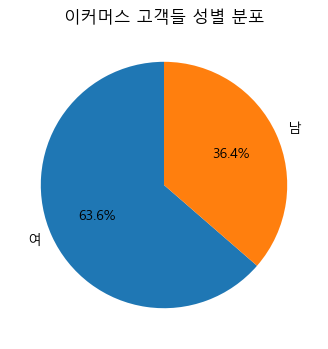

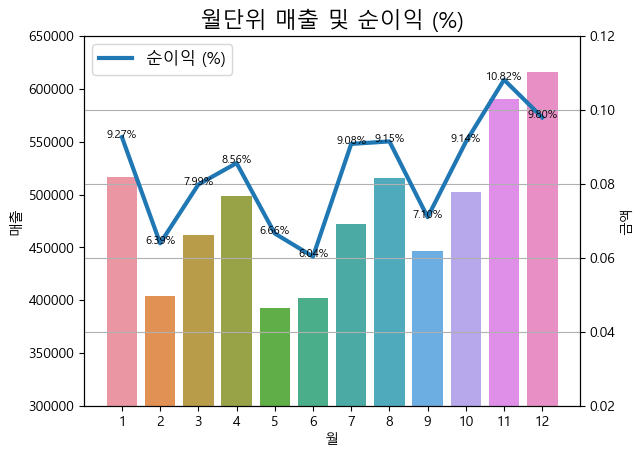

In [64]:
customer_gender = customer['성별'].value_counts()
plt.figure(figsize=(5, 4)) 
customer_gender.plot(kind='pie', autopct='%1.1f%%', startangle=90)  
plt.title('이커머스 고객들 성별 분포')  
plt.ylabel('')
plt.show()

plt_monthly_sales = month_df[['월', '매출', '순이익 (%)']]
fig, ax1 = plt.subplots()
ax1 = sns.barplot(x='월', y='매출', data=plt_monthly_sales, ci=None, label='매출')
ax2 = ax1.twinx()
sns.lineplot(x=plt_monthly_sales['월']-1, y='순이익 (%)', data=plt_monthly_sales, ci=None, label='순이익 (%)', linewidth=3)
for i in range(len(plt_monthly_sales)):
    plt.text(x=plt_monthly_sales['월'][i]-1, y=plt_monthly_sales['순이익 (%)'][i], s="{:.2f}%".format(plt_monthly_sales['순이익 (%)'][i]*100), ha='center', fontsize=8)
plt.xlabel('월')
plt.ylabel('금액')
plt.title('월단위 매출 및 순이익 (%)', fontsize=16)
plt.legend(fontsize='large', loc = 'upper left')
plt.grid(True)
ax1.set_ylim(300000, 650000)
ax2.set_ylim(0.02, 0.12)
plt.show()

✅ Data Insights

여성이 상대적으로 많은 이커머스

< 매출 및 순이익 >
- 1월, 4월, 8월, 12월에 매출이 올라가는 추세

- 특히 연말/연초 일수록 매출과 영업이익이 동시에 상승하는 추세

## 월별 총거래수, 평균거래수 확인

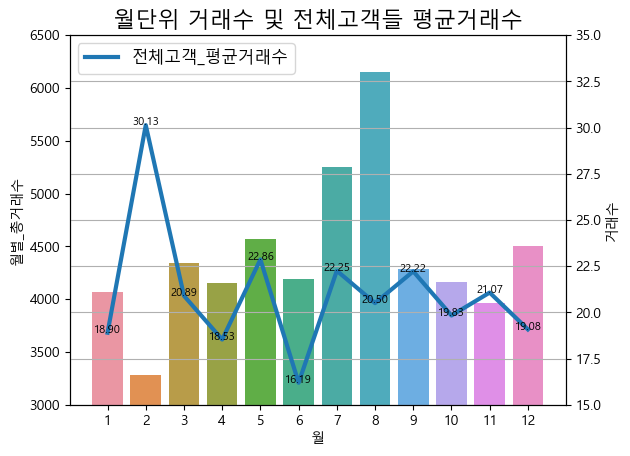

In [65]:
plt_monthly_count = month_df[['월', '전체고객_평균거래수', '월별_총거래수']]
fig, ax1 = plt.subplots()
ax1 = sns.barplot(x='월', y='월별_총거래수', data=plt_monthly_count, ci=None, label='월별_총거래수', linewidth=3)
ax2 = ax1.twinx()
sns.lineplot(x=plt_monthly_count['월']-1, y='전체고객_평균거래수', data=plt_monthly_count, ci=None, label='전체고객_평균거래수', linewidth=3)
for i in range(len(plt_monthly_count)):
    plt.text(x=plt_monthly_count['월'][i]-1, y=plt_monthly_count['전체고객_평균거래수'][i], s="{:.2f}".format(plt_monthly_count['전체고객_평균거래수'][i]), ha='center', fontsize=8)
plt.xlabel('월')
plt.ylabel('거래수')
plt.title('월단위 거래수 및 전체고객들 평균거래수', fontsize=16)
plt.legend(fontsize='large', loc = 'upper left')
plt.grid(True)
ax1.set_ylim(3000, 6500)
ax2.set_ylim(15, 35)
plt.show()

✅ Data Insights

- 매출과 반대로 2월에 전체 고객들의 평균거래수가 높게 측정되고 총거래수는 낮게 나옴. (확인할 필요 有)

-> 2월에 평균적으로 고객 일부가 제품을 상당히 많이 구매한 것을 알 수 있음. (빈도수가 높음)

- 6월 평균 거래수는 낮게 나온 것으로 보아 많은 고객들이 제품을 구매한 것을 알 수 있음
- 12월에 총거래수와 평균거래수는 연평균 대비 비슷하지만 매출은 높게 측정되었으므로, 평균적으로 구매한 금액이 높음을 알 수 있음.

## 월별 전체고객 평균주문금액 EDA

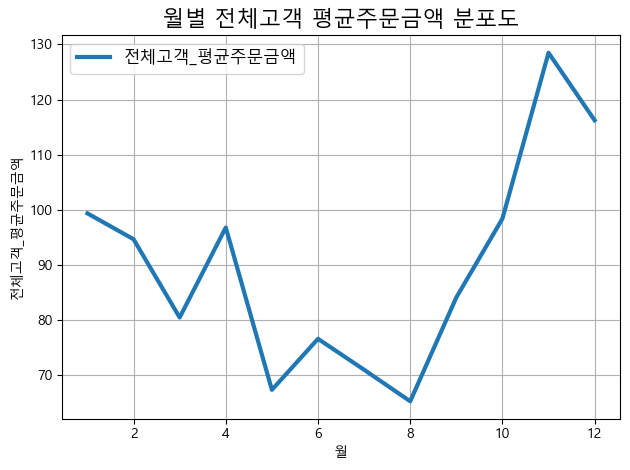

In [66]:
plt.title('월별 전체고객 평균주문금액 분포도', fontsize=16)
sns.lineplot(x='월', y='전체고객_평균주문금액', data=month_df, ci=None, label='전체고객_평균주문금액', linewidth=3)
plt.xlabel('월')
plt.ylabel('전체고객_평균주문금액')
plt.legend(fontsize='large')
plt.grid(True)
plt.tight_layout()
plt.show()

✅ Data Insights

- 월별 총거래수와 반비례하여 여름으로 갈수록 평균적으로 주문금액이 하락하는 추세 확인 가능.
- 매출과 연관되어 연말로 갈수록 평균적으로 주문하는 금액이 높아지는 추세 확인 가능.

## 월별 온/오프라인 마케팅 비용 EDA

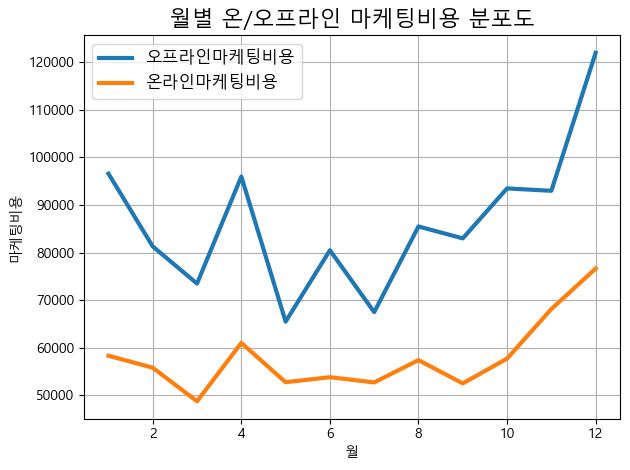

In [67]:
plt.title('월별 온/오프라인 마케팅비용 분포도', fontsize=16)
sns.lineplot(x='월', y='오프라인비용', data=month_df, ci=None, label='오프라인마케팅비용', linewidth=3)
sns.lineplot(x='월', y='온라인비용', data=month_df, ci=None, label='온라인마케팅비용', linewidth=3)
plt.xlabel('월')
plt.ylabel('마케팅비용')
plt.legend(fontsize='large')
plt.grid(True)
plt.tight_layout()
plt.show()

✅ Data Insights

- 온/오프라인 마케팅 비율은 오프라인 비용이 훨씬 높은 추세 (약 1.7배 정도)
- 연말에 가까울수록 매출 상승과 비슷하게 마케팅 비용 역시 상승하는 추세

## 월별 배송료 EDA

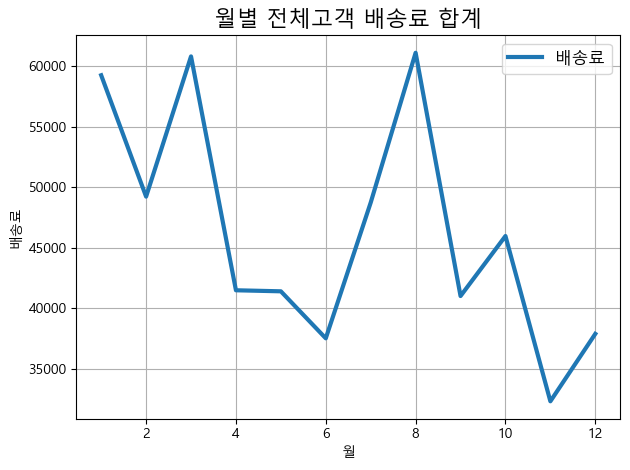

In [68]:
delivery_month = online.groupby('월')['배송료'].sum().reset_index()
plt.title('월별 전체고객 배송료 합계', fontsize=16)
sns.lineplot(x='월', y='배송료', data=delivery_month, ci=None, label='배송료', linewidth=3)
plt.xlabel('월')
plt.ylabel('배송료')
plt.legend(fontsize='large')
plt.grid(True)
plt.tight_layout()
plt.show()

✅ Data Insights

3월과 8월의 배송료가 매우 높고 매출에 가장 높았던 11월과 12월은 배송료 합계가 상당히 낮은 모습.

연말의 경우 배송료가 적은 것으로 보아 제품 순수 판매 이익이 높았던 점 알 수 있음.

# 비즈니스 솔루션 제시 

## Solution 1. 이커머스 특성 기반 유저 평균 구매 주기를 줄이는 프로모션 제안.

In [69]:
membership_sort = membership.sort_values(by=['인당 매출'], ascending=False)
membership_sort[['RFM_class', '인당 매출', '고객수', '매출', '매출 비중']]

,RFM_class,인당 매출,고객수,매출,매출 비중
6,VVIP,19491.289066,64,1.247443e+06,0.214344
5,VIP,10147.919444,126,1.278638e+06,0.219704
1,GOLD,6646.276124,145,9.637100e+05,0.165591
3,SILVER,3727.134386,133,4.957089e+05,0.085176
2,FAMILY,2170.117790,135,2.929659e+05,0.050339
0,ONETIME,1876.445254,734,1.377311e+06,0.236659
4,MEMBER,1252.234637,131,1.640427e+05,0.028187


✅ Data Insights

- 인당 매출을 기준으로 고객 등급이 잘 분류된 점 확인 가능.
- 등급별로 매출과 영업이익에 긍정적인 영향 주는 요소 파악하여 비즈니스 솔루션 제시하기.

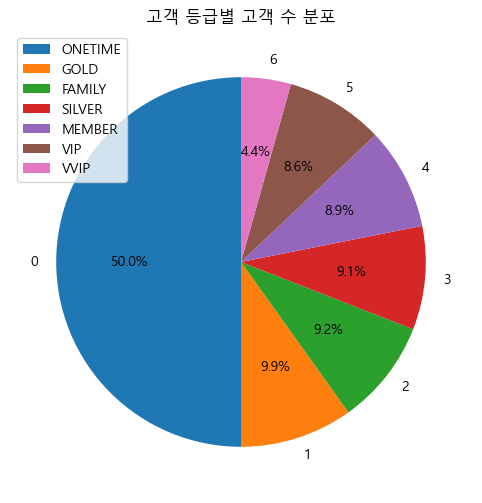

<Axes: title={'center': '2019년 고객등급 별 거래 당 평균주문금액'}, xlabel='RFM_class', ylabel='평균주문금액'>

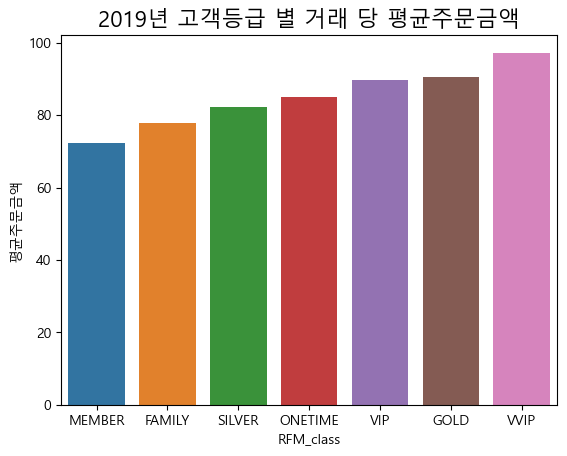

In [70]:
plt.figure(figsize=(12, 6)) 
membership['고객수'].plot(kind='pie', autopct='%1.1f%%', startangle=90)  
plt.legend(labels=membership.RFM_class, loc="best")
plt.title('고객 등급별 고객 수 분포')  
plt.ylabel('')
plt.show()

membership.sort_values(by='평균주문금액', ascending=True, inplace=True)
plt.title('2019년 고객등급 별 거래 당 평균주문금액', fontsize=16)
sns.barplot(data=membership, x="RFM_class", y="평균주문금액")

✅ Data Insights

VIP와 (Silver, Family, Member) 평균 주문 금액 차이를 봤을 때 

거래당 주문 금액 차이 약 0.75~0.85배. 

인당 매출 약 5- 15배. 차이

- 결국 주문 금액 차이에 비해 매출 차이가 큰 폭으로 차이나는 상황.

- 고객 등급은 매출 주문 횟수, 주문 금액에 비례.


In [71]:
# 평균구매주기 합치기.
merge_customer_data = customer_df[['고객ID', '평균구매주기']]
final_df_as = pd.merge(final_df, merge_customer_data, on=['고객ID'], how='left')
# Onetime 고객들은 1년간 1회만 거래했으므로 처리.
final_df_as['평균구매주기'] = final_df_as['평균구매주기'].fillna(0)

vvip = final_df_as[final_df_as['RFM_class'] == 'VVIP']
vip = final_df_as[final_df_as['RFM_class'] == 'VIP']
gold = final_df_as[final_df_as['RFM_class'] == 'GOLD']
silver = final_df_as[final_df_as['RFM_class'] == 'SILVER']
family = final_df_as[final_df_as['RFM_class'] == 'FAMILY']
member = final_df_as[final_df_as['RFM_class'] == 'MEMBER']
onetime = final_df_as[final_df_as['RFM_class'] == 'ONETIME']

In [72]:
# 2019년 1년간 
print('VVIP 회원들 2019년 평균 거래 간격 ', vvip['평균구매주기'].mean())
print('VIP 회원들 2019년 평균 거래 간격 ', vip['평균구매주기'].mean())
print('GOLD 회원들 2019년 평균 거래 간격 ', gold['평균구매주기'].mean())
print('SILVER 회원들 2019년 평균 거래 간격 ', silver['평균구매주기'].mean())
print('FAMILY 회원들 2019년 평균 거래 간격 ', family['평균구매주기'].mean())
print('MEMBER 회원들 2019년 평균 거래 간격 ', member['평균구매주기'].mean())
print('ONETIME 회원들 2019년 평균 거래 간격 ', onetime['평균구매주기'].mean())

VVIP 회원들 2019년 평균 거래 간격  23.832203061422206
VIP 회원들 2019년 평균 거래 간격  41.29863228504225
GOLD 회원들 2019년 평균 거래 간격  69.9954808806489
SILVER 회원들 2019년 평균 거래 간격  70.93157237936772
FAMILY 회원들 2019년 평균 거래 간격  96.46523178807946
MEMBER 회원들 2019년 평균 거래 간격  125.71952595936794
ONETIME 회원들 2019년 평균 거래 간격  0.0


<Axes: title={'center': '고객 등급별 2019년 평균구매주기 비교'}, xlabel='RFM_class', ylabel='평균구매주기'>

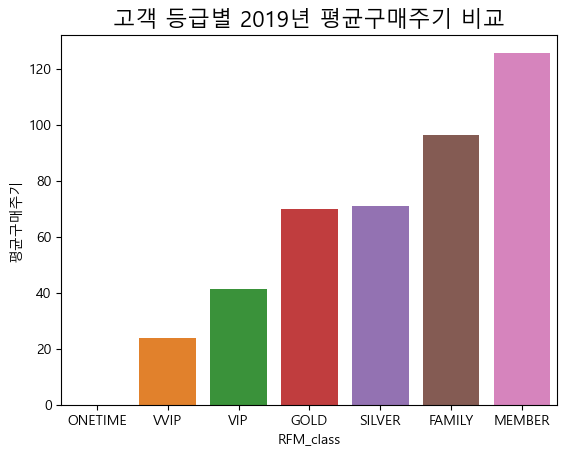

In [73]:
visual = final_df_as.groupby(['RFM_class'])['평균구매주기'].mean().reset_index()
visual = pd.DataFrame(visual)
visual = visual.sort_values(by='평균구매주기', ascending=True)
plt.title('고객 등급별 2019년 평균구매주기 비교', fontsize=16)
sns.barplot(data=visual, x="RFM_class", y="평균구매주기")

In [74]:
membership.sort_values(by='인당 매출', ascending=False)

,RFM_class,고객수,매출,주문금액,평균주문금액,인당 매출,매출 비중
6,VVIP,64,1.247443e+06,1003683.67,97.237325,19491.289066,0.214344
5,VIP,126,1.278638e+06,1029649.05,89.698497,10147.919444,0.219704
1,GOLD,145,9.637100e+05,780834.65,90.479102,6646.276124,0.165591
3,SILVER,133,4.957089e+05,395721.72,82.304850,3727.134386,0.085176
2,FAMILY,135,2.929659e+05,235428.50,77.956457,2170.117790,0.050339
0,ONETIME,734,1.377311e+06,1097372.52,85.113823,1876.445254,0.236659
4,MEMBER,131,1.640427e+05,128104.51,72.293742,1252.234637,0.028187


✨ Solution 1.이커머스 특성 기반 유저 평균 구매 주기를 줄이는 프로모션 제안

💡 가설 및 제안 배경

즉, 현재 A 커머스의 고객 특징을 보았을 때 거래당 매출(VVIP <> MEMBER 0.85배)에 영향을 많이 받는 것보다 고객의 구매 주기(VVIP <> MEMBER 약 6배)에 따른 영향을 받는 기업임을 알 수 있음


💡 솔루션 제안 내용

1. GOLD, SILVER, MEMBER, FAMILY 그룹 대상

- 구매 주기가 상대적으로 낮은 고객에게는 플랫폼 방문 주기를 늘려 구매 주기 단축을 이룰 수 있는 프리퀀시 이벤트 수행.

-> ex. 출석 이벤트 : 일별로 플랫폼 방문 시 출석 인증을 수행하고, 5회 / 10회 이상부터 할인 코드를 제공하는 이벤트 진행.

2. ONETIME 그룹 대상
- 첫 주문 후의 리텐션률을 유지 시키는 것이 장기 미방문자를 줄이는 가장 중요한 방법. 
- 그에 따라 첫 주문을 한 유저에 대해서는 주문 리텐션률을 높힐 수 있는 쿠폰팩을 지급하여, 유저의 초기 주문 주기를 줄인다.

-> ex. 첫 주문 리텐션 쿠폰팩 : 첫 주문 후 5% 할인이 적용되는 쿠폰 2매 지급. 2주 내 사용 가능.



❗ 예상 효과

VVIP 회원 100 달러 상승 대비 타 등급별 인당 매출액 증가량은 다음과 같다.
- VIP : 52.06 달러
- GOLD : 34.1 달러
- SILVER : 19.12 달러
- FAMILY : 11.14 달러
- MEMBER : 6.42 달러

결국 앞선 솔루션에서 제안한 이벤트를 기반으로 각 등급의 10% 인원이 최상위 등급인 VVIP로 전환된다고 가정하면  
플랫폼 매출액은 다음과 같이 상승 가능.

- VIP : 12.6名 * (100% + 92.07%)  = 2420.10 달러 상승 가능 (기존 VIP회원 10%의 인당 100달러 매출 발생 대비)

- GOLD : 14.5名 * (100% + 193.27%) = 4252.415 달러 상승 가능 (기존 GOLD회원 10%의 인당 100달러 매출 발생 대비)
- SILVER : 13.3名 * (100% + 422.96%) = 6955.32 달러 상승 가능 (기존 SILVER회원 10%의 인당 100달러 매출 발생 대비)
- FAMILY : 13.5名 * (100% + 798.17%) = 12125.26 달러 상승 가능 (기존 FAMILY회원 10%의 인당 100달러 매출 발생 대비)
- MEMBER : 13.1名 * (100 % + 1456.52%) = 20390.412 달러 상승 가능 (기존 MEMBER회원 10%의 인당 100달러 매출 발생 대비)

## Solution 2. 쿠폰 할인 축소 A/B 테스트 진행하여 커머스 비용 축소

가설. 본인 거래 중 70% 
이커머스 기업의 이익 증대를 위해 고객 전체를 대상으로 쿠폰 사용이 낮은 고객들에 한해 할인율을 낮추는 AB테스트 진행



In [75]:
final_df['쿠폰상태'].value_counts()

Clicked     26926
Used        17904
Not Used     8094
Name: 쿠폰상태, dtype: int64

In [76]:
sales_coupon = final_df.groupby(['쿠폰상태'])['매출'].sum().reset_index()
sales_coupon['쿠폰 별 매출비중'] = sales_coupon['매출'] * 100 / sum(sales_coupon['매출'])
sales_coupon.sort_values(by='쿠폰 별 매출비중', ascending=False)

,쿠폰상태,매출,쿠폰 별 매출비중
0,Clicked,2.965792e+06,50.960213
2,Used,1.944923e+06,33.418970
1,Not Used,9.091033e+05,15.620818


✅ Data Insights

온라인 거래 총 52924회 중 쿠폰 상태 별 매출 비중은 다음과 같다.

- Clicked (쿠폰을 클릭만 하고 사용하지 않은 경우) : 전체 거래 중 50.88% 이고, 매출 비중 역시 이와 비슷한 50.96%로 절반 이상 차지.
- Used (쿠폰을 사용한 경우) : 전체 거래 중 33.82% 이고, 매출 비중 이와 비슷한 역시 33.42%.
- Not Used (쿠폰을 사용하지 않은 경우) : 전체 거래 중 15.92%이고, 매출 비중은 15.62%.
    
    - 쿠폰을 사용하지 않았을 때 매출 비중이 낮게 나옴.
    - 전체적으로 쿠폰을 사용하지 않은 비중이 높다.


> - 따라서 본인 거래 중 쿠폰을 사용하지 않은 비율이 70%가 넘는 고객들에 한해 쿠폰 할인율을 낮추는 AB 테스팅 제안.

In [77]:
# 등급별 쿠폰 상태에 따른 매출 비율 계산
sales_class_coupon = final_df.groupby(['RFM_class', '쿠폰상태'])['매출'].sum().reset_index()
sales_by_rfm_coupon = sales_class_coupon.groupby(['RFM_class', '쿠폰상태'])['매출'].sum().unstack(fill_value=0)
sales_by_rfm_coupon_ratio = sales_by_rfm_coupon.div(sales_by_rfm_coupon.sum(axis=1), axis=0)
sales_by_rfm_coupon_ratio

쿠폰상태,Clicked,Not Used,Used
RFM_class,,,
FAMILY,0.525760,0.148329,0.325911
GOLD,0.506906,0.165891,0.327203
MEMBER,0.473474,0.172318,0.354208
ONETIME,0.512695,0.149521,0.337784
SILVER,0.510587,0.145803,0.343609
VIP,0.507206,0.161069,0.331725
VVIP,0.511291,0.154996,0.333714


✅ Data Insights

등급별 쿠폰 상태에 따른 매출 비중은 다음과 같다. 
- 매출 비중이 제일 적은 MEMBER의 경우 쿠폰을 제일 많이 사용한 것으로 확인할 수 있다.

따라서 쿠폰 사용률이 70%가 넘는 고객들에 한해 쿠폰 할인율을 낮추는 전략을 세워 기업의 이익을 높일 수 있다.

FAMILY    55
MEMBER    44
GOLD      42
SILVER    39
VIP       33
VVIP      13
Name: RFM_class, dtype: int64


<Axes: title={'center': '고객등급별 쿠폰 할인율 낮출 고객 수'}, xlabel='고객 등급', ylabel='쿠폰 비용 축소 고객 수'>

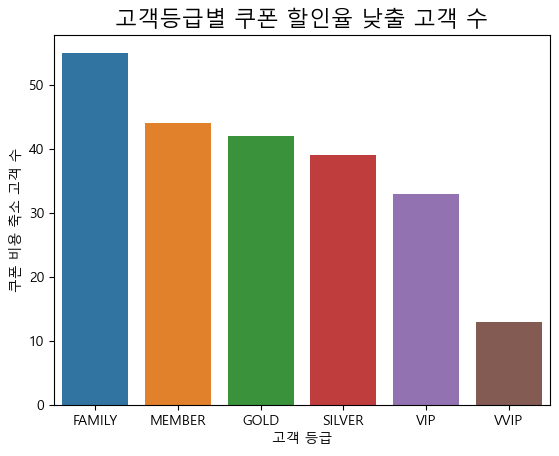

In [81]:
class_check = final_df[['고객ID', 'RFM_class']]
class_check.drop_duplicates(inplace=True)
class_effi = class_check[class_check['RFM_class'] != 'ONETIME']

class_df = final_df.groupby(['고객ID', '쿠폰상태']).size().reset_index(name='거래건수')
pivot_class_df = class_df.pivot_table(index='고객ID', columns='쿠폰상태', values='거래건수', fill_value=0).reset_index()
pivot_class_df['쿠폰사용안한비중'] = (pivot_class_df['Not Used'] + pivot_class_df['Clicked']) / (pivot_class_df['Clicked'] + pivot_class_df['Not Used'] + pivot_class_df['Used'])

pivot_final_df = pd.merge(class_effi, pivot_class_df, on=['고객ID'])
reduce_discount = pivot_final_df[pivot_final_df['쿠폰사용안한비중'] > 0.7]

visual_reduce_discount = reduce_discount['RFM_class'].value_counts()
print(visual_reduce_discount)
visual_reduce_discount = pd.DataFrame(visual_reduce_discount)
visual_reduce_discount.reset_index(drop=False, inplace=True)
visual_reduce_discount.rename(columns={'index':'고객 등급', 'RFM_class':'쿠폰 비용 축소 고객 수'}, inplace=True)

plt.title('고객등급별 쿠폰 할인율 낮출 고객 수', fontsize=16)
sns.barplot(data=visual_reduce_discount, x="고객 등급", y="쿠폰 비용 축소 고객 수")

In [82]:
class_discount = final_df.groupby(['RFM_class'])['할인금액'].sum().reset_index()
membership_discount = pd.merge(membership, class_discount, on = ['RFM_class'])
membership_discount['인당 할인금액'] = membership_discount['할인금액'] / membership_discount['고객수']
membership_discount

,RFM_class,고객수,매출,주문금액,평균주문금액,인당 매출,매출 비중,할인금액,인당 할인금액
0,MEMBER,131,1.640427e+05,128104.51,72.293742,1252.234637,0.028187,9228.695,70.448053
1,FAMILY,135,2.929659e+05,235428.50,77.956457,2170.117790,0.050339,15209.972,112.666459
2,SILVER,133,4.957089e+05,395721.72,82.304850,3727.134386,0.085176,28706.804,215.840632
3,ONETIME,734,1.377311e+06,1097372.52,85.113823,1876.445254,0.236659,75174.061,102.416977
4,VIP,126,1.278638e+06,1029649.05,89.698497,10147.919444,0.219704,68024.504,539.877016
5,GOLD,145,9.637100e+05,780834.65,90.479102,6646.276124,0.165591,51961.024,358.351890
6,VVIP,64,1.247443e+06,1003683.67,97.237325,19491.289066,0.214344,62467.398,976.053094


✨ Solution 2. 쿠폰 할인 축소 A/B 테스트 진행하여 커머스 비용 축소.

💡 가설 및 제안 배경

- 총 주문 수 대비하여 쿠폰 미사용 주문 건이 많은 유저일수록, 쿠폰 제공 없이 Organic하게 주문 전환하는 가능성이 높은 유저라 가정. 

- 이에 따라 총 주문 대비 쿠폰 미사용 주문 건이 70% 이상인 유저의 경우에는 상대적으로 쿠폰 혜택을 감축시켜도 구매 감소가 거의 없을 것으로 예상.

- 단 Onetime 고객 그룹에 한해서는 해당 솔루션 제공 X, 연간 2일 이상 거래한 그룹에만 적용.

💡 실험

- 해당 유저군에게는 쿠폰 비용을 50%로 축소하는 A/B 테스트 진행. (ex. 10% 할인 > 5% 할인),
- 해당 유저 군내 실험군:대조군 5:5 설정 후 할인 금액 10%:5%로 나눠 테스트 진행.


❗ 예상 효과

테스트 이전 기존 주문 수 대비 주문 건수가 5% 미만으로 감소하거나, 비슷하게 유지된다면 최대 5%의 비용 감축 효과. 

(수익 =  주문 1건당 이익 * (1-할인율) * 주문 건수, 이기 때문에 1건당 할인율이 5% 개선된 만큼, 주문 건수가 5% 하락하지만 않으면 비즈니스 입장에서 이익인 결과.)

현재 해당 고객 등급별 인당 할인금액은 다음과 같다. 
VVIP       976.053094
VIP        539.877016
GOLD       358.351890
SILVER     215.840632
FAMILY     112.666459
MEMBER     70.448053
ONETIME    102.416977

따라서 앞서 선정한 그룹군에 5% 할인율 감소할 경우 다음과 같다.

- 감축금액 : (VVIP : 13名 * 488.026547) + (VIP : 33名 * 269.938508) + (GOLD : 42名 * 179.175945) + (SILVER : 39名 * 107.920316) + (FAMILY : 55名 * 112.666459) + (MEMBER : 44名 * 70.448053)

연간 최대 36282.967466 달러의 금액 감축으로 기업 이익 증진 효과 기대 가능.

단, 추가적으로 테스트 긍정적 반응 시에 유저 그룹 확대 판단 필요.

## Solution 3. VIP 고객 로얄티 증대를 위한 프로모션 진행으로 매출 확대

In [83]:
membership = membership.sort_values(by=['인당 매출'], ascending=False)
membership[['RFM_class', '고객수', '매출', '인당 매출', '매출 비중']]

,RFM_class,고객수,매출,인당 매출,매출 비중
6,VVIP,64,1.247443e+06,19491.289066,0.214344
5,VIP,126,1.278638e+06,10147.919444,0.219704
1,GOLD,145,9.637100e+05,6646.276124,0.165591
3,SILVER,133,4.957089e+05,3727.134386,0.085176
2,FAMILY,135,2.929659e+05,2170.117790,0.050339
0,ONETIME,734,1.377311e+06,1876.445254,0.236659
4,MEMBER,131,1.640427e+05,1252.234637,0.028187


In [84]:
print('VVIP 회원 수 :', len(vvip['고객ID'].unique()))
print('VVIP 회원들 총 거래수 : ', len(vvip))
print('전체 대비 VVIP 회원들 거래 비율 : ', f'{len(vvip)*100 / len(final_df_as):.2f}%')
print('VVIP 회원 중 최소 연간 거래 횟수 : ', vvip['고객ID'].value_counts().min())
print('VVIP 회원들 평균 구매 주기 : ', vvip['평균구매주기'].mean())
print('-'*80)
print('VIP 회원 수 :', len(vip['고객ID'].unique()))
print('VIP 회원들 총 거래수 : ', len(vip))
print('전체 대비 VIP 회원들 거래 비율 : ', f'{len(vip)*100 / len(final_df_as):.2f}%')
print('VIP 회원 중 최소 연간 거래 횟수 : ', vip['고객ID'].value_counts().min())
print('VIP 회원들 평균 구매 주기 : ', vip['평균구매주기'].mean())

VVIP 회원 수 : 64
VVIP 회원들 총 거래수 :  10322
전체 대비 VVIP 회원들 거래 비율 :  19.50%
VVIP 회원 중 최소 연간 거래 횟수 :  50
VVIP 회원들 평균 구매 주기 :  23.832203061422206
--------------------------------------------------------------------------------
VIP 회원 수 : 126
VIP 회원들 총 거래수 :  11479
전체 대비 VIP 회원들 거래 비율 :  21.69%
VIP 회원 중 최소 연간 거래 횟수 :  31
VIP 회원들 평균 구매 주기 :  41.29863228504225


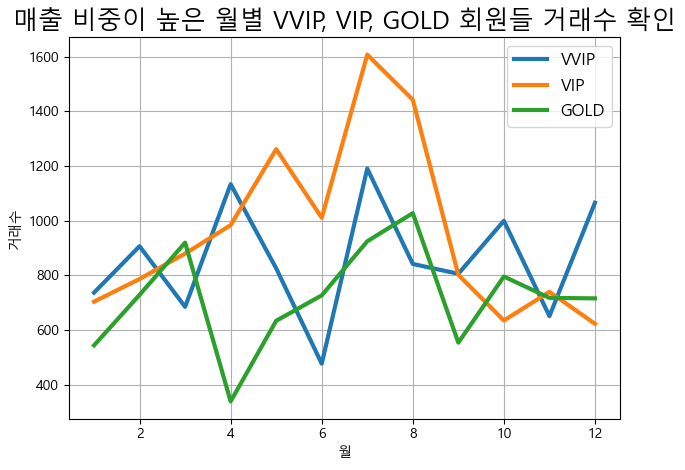

In [85]:
vvip_count = vvip.groupby(['월']).size().reset_index(name='거래수')
vvip_count.rename(columns={'거래수':'VVIP_거래수'}, inplace=True)
vip_count = vip.groupby(['월']).size().reset_index(name='거래수')
vip_count.rename(columns={'거래수':'VIP_거래수'}, inplace=True)
gold_count = gold.groupby(['월']).size().reset_index(name='거래수')
gold_count.rename(columns={'거래수':'GOLD_거래수'},inplace=True)

cnt=pd.merge(vvip_count, vip_count, on=['월']).merge(gold_count, on=['월'])
plt.title('매출 비중이 높은 월별 VVIP, VIP, GOLD 회원들 거래수 확인', fontsize=18)
sns.lineplot(x='월', y='VVIP_거래수', data=cnt, ci=None, label='VVIP', linewidth=3)
sns.lineplot(x='월', y='VIP_거래수', data=cnt, ci=None, label='VIP', linewidth=3)
sns.lineplot(x='월', y='GOLD_거래수', data=cnt, ci=None, label='GOLD', linewidth=3)
plt.xlabel('월')
plt.ylabel('거래수')
plt.legend(fontsize='large')
plt.grid(True)
plt.tight_layout()
plt.show()

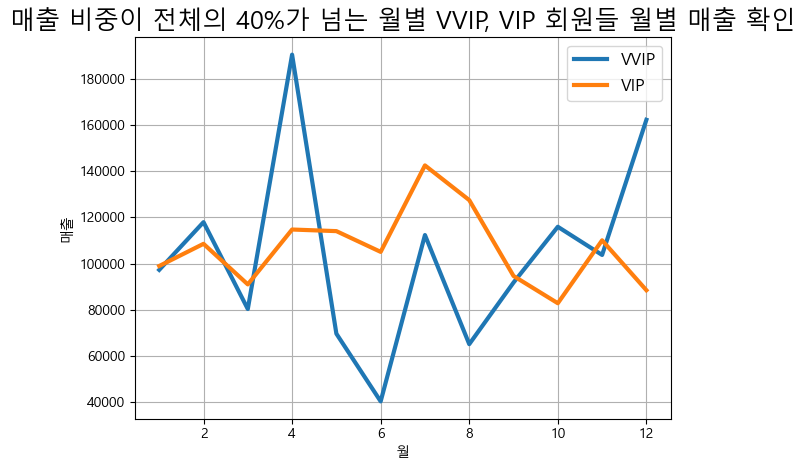

In [86]:
vvip_sales = vvip.groupby(['월'])['매출'].sum().reset_index()
vvip_sales.rename(columns={'매출': 'VVIP 회원 매출'}, inplace=True)

vip_sales = vip.groupby(['월'])['매출'].sum().reset_index()
vip_sales.rename(columns={'매출': 'VIP 회원 매출'}, inplace=True)

plt.title('매출 비중이 전체의 40%가 넘는 월별 VVIP, VIP 회원들 월별 매출 확인', fontsize=18)
sns.lineplot(x='월', y='VVIP 회원 매출', data=vvip_sales, ci=None, label='VVIP', linewidth=3)
sns.lineplot(x='월', y='VIP 회원 매출', data=vip_sales, ci=None, label='VIP', linewidth=3)
plt.xlabel('월')
plt.ylabel('매출')
plt.legend(fontsize='large')
plt.grid(True)
plt.tight_layout()
plt.show()

✅ Data Insights

- 4월과 12월 VVIP 대비 VIP 매출 차이가 크게 뒤쳐지는 편 발견.


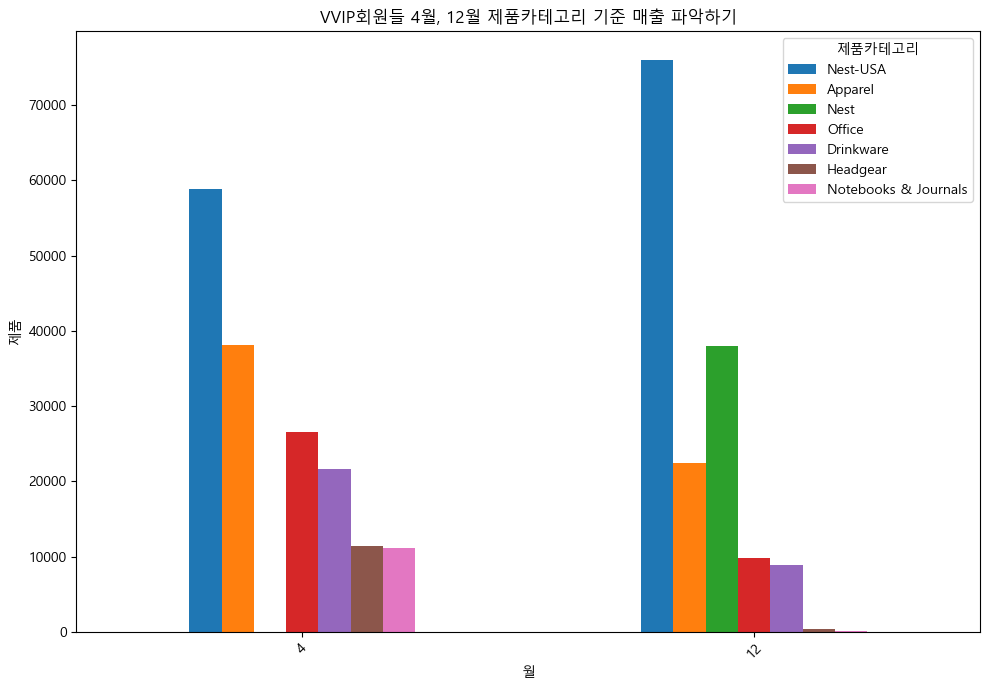

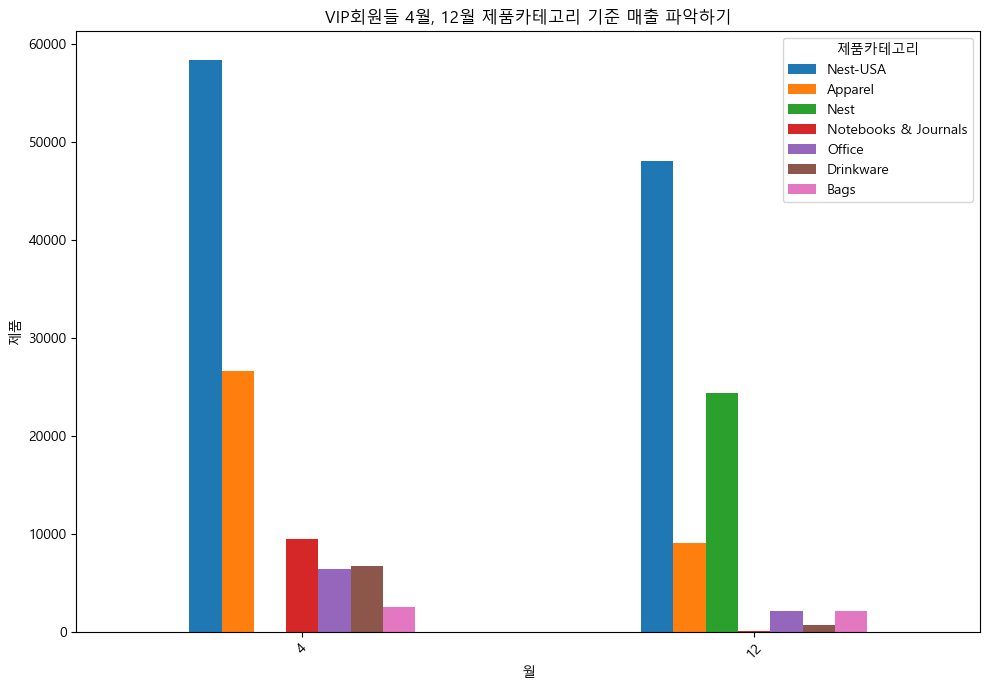

In [111]:
monthly_sales = vvip.groupby(['월', '제품카테고리'])['매출'].sum().unstack()
two_month_sales = monthly_sales[(monthly_sales.index == 4) | (monthly_sales.index==12)]
# 4월 12월에 한해 상위 5개 제품만 비교
top_products = two_month_sales.sum().nlargest(7).index
monthly_sales_top = two_month_sales[top_products]
monthly_sales_top.plot(kind='bar', figsize=(10, 7))
plt.title('VVIP회원들 4월, 12월 제품카테고리 기준 매출 파악하기')
plt.xlabel('월')
plt.ylabel('제품')
plt.legend(title='제품카테고리')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

monthly_sales = vip.groupby(['월', '제품카테고리'])['매출'].sum().unstack()
two_monthly_sales = monthly_sales[(monthly_sales.index == 4) | (monthly_sales.index==12)]
# 상위 5개 제품만 비교
top_products = two_monthly_sales.sum().nlargest(7).index
monthly_sales_top = two_monthly_sales[top_products]
monthly_sales_top.plot(kind='bar', figsize=(10, 7))
plt.title('VIP회원들 4월, 12월 제품카테고리 기준 매출 파악하기')
plt.xlabel('월')
plt.ylabel('제품')
plt.legend(title='제품카테고리')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

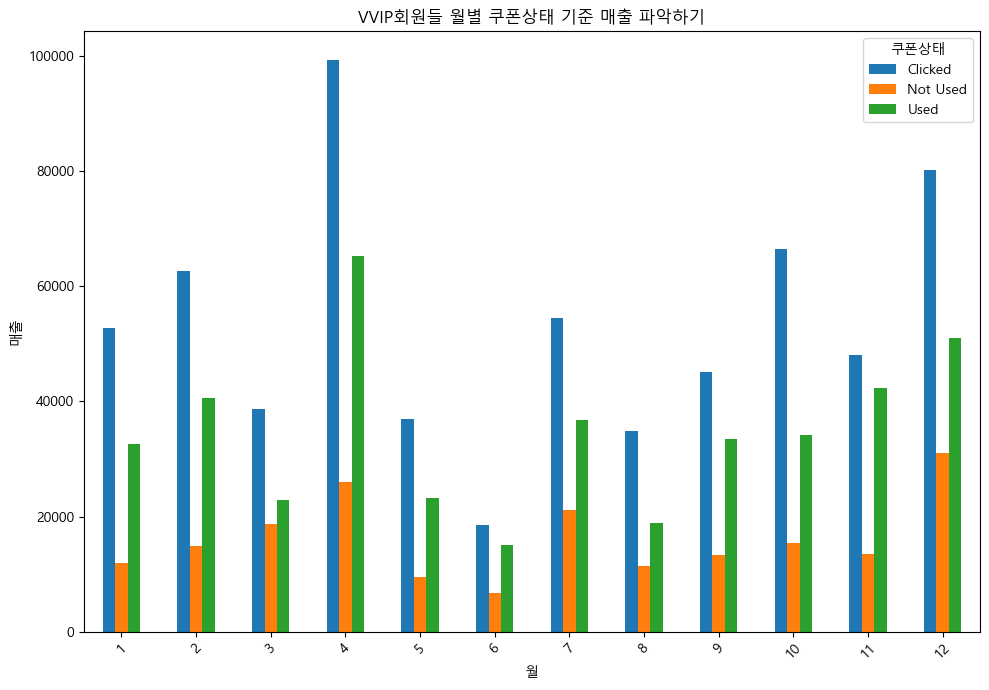

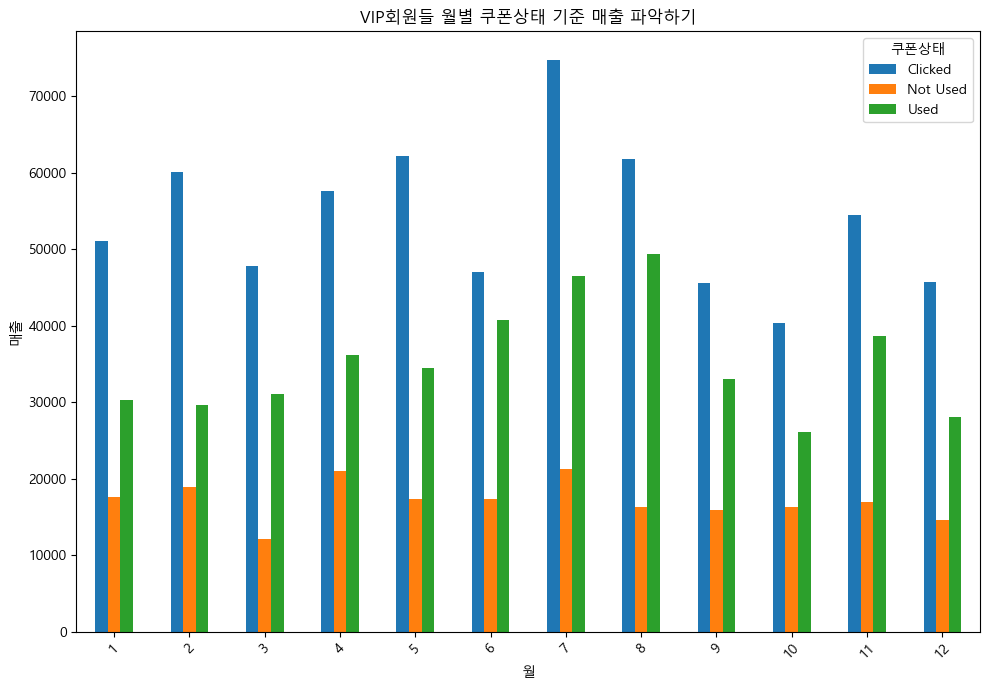

In [104]:
vvip_coupon_visual = vvip.groupby(['월', '쿠폰상태'])['매출'].sum().unstack()
vvip_coupon_visual.plot(kind='bar', figsize=(10, 7))
plt.title('VVIP회원들 월별 쿠폰상태 기준 매출 파악하기')
plt.xlabel('월')
plt.ylabel('매출')
plt.legend(title='쿠폰상태')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


vip_coupon_visual = vip.groupby(['월', '쿠폰상태'])['매출'].sum().unstack()
vip_coupon_visual.plot(kind='bar', figsize=(10, 7))
plt.title('VIP회원들 월별 쿠폰상태 기준 매출 파악하기')
plt.xlabel('월')
plt.ylabel('매출')
plt.legend(title='쿠폰상태')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

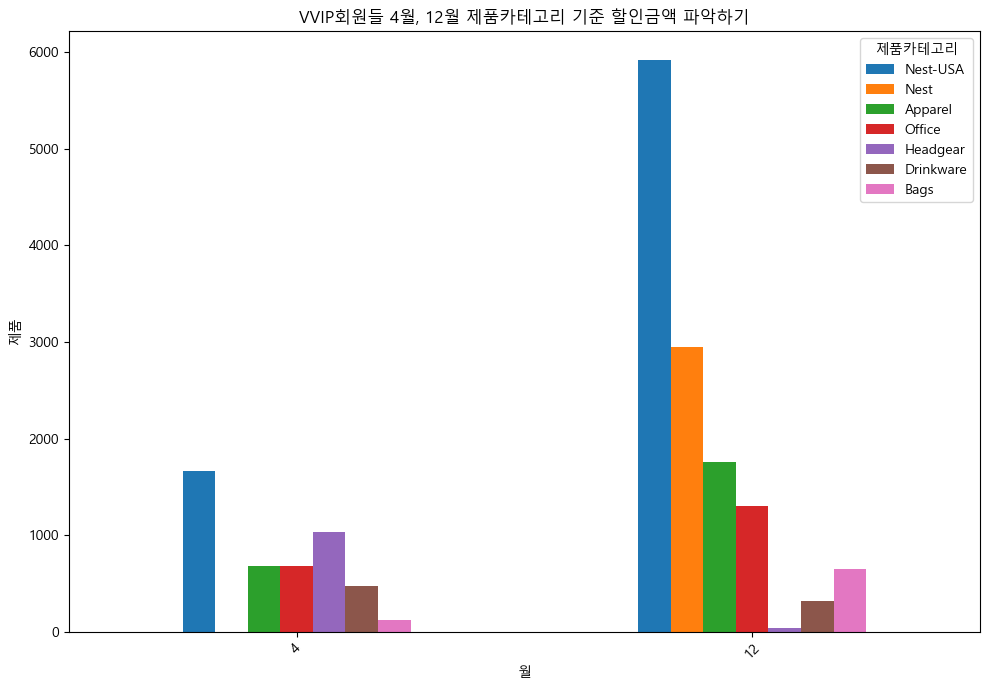

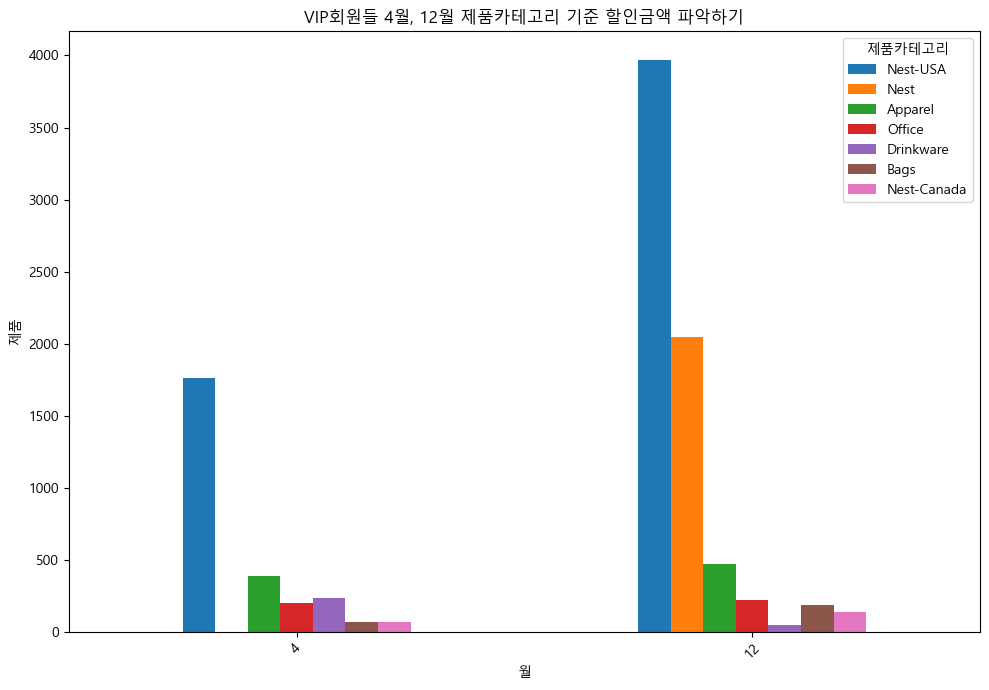

In [112]:
monthly_discount = vvip.groupby(['월', '제품카테고리'])['할인금액'].sum().unstack()
two_monthly_vvip_discount = monthly_discount[(monthly_discount.index == 4) | (monthly_discount.index==12)]
# 상위 5개 제품만 비교
top_products = two_monthly_vvip_discount.sum().nlargest(7).index
monthly_sales_top = two_monthly_vvip_discount[top_products]
monthly_sales_top.plot(kind='bar', figsize=(10, 7))
plt.title('VVIP회원들 4월, 12월 제품카테고리 기준 할인금액 파악하기')
plt.xlabel('월')
plt.ylabel('제품')
plt.legend(title='제품카테고리')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


monthly_discount = vip.groupby(['월', '제품카테고리'])['할인금액'].sum().unstack()
two_monthly_vip_discount = monthly_discount[(monthly_discount.index == 4) | (monthly_discount.index==12)]
# 상위 5개 제품만 비교
top_products = two_monthly_vip_discount.sum().nlargest(7).index
monthly_sales_top = two_monthly_vip_discount[top_products]
monthly_sales_top.plot(kind='bar', figsize=(10, 7))
plt.title('VIP회원들 4월, 12월 제품카테고리 기준 할인금액 파악하기')
plt.xlabel('월')
plt.ylabel('제품')
plt.legend(title='제품카테고리')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

✨ Solution 3. VIP 고객 로얄티 증대를 위한 프로모션 진행으로 매출 확대

< 4월 >
- VIP 회원들과 VVIP 회원들의 제품별 매출액을 비교하면 다음과 같음. 
- 1,2 순위인 Nest-USA, Apparel 제품 카테고리의 매출액은 유사하다고 볼 수 있지만 다음 품목에서 매출차이를 극명히 보임.

제품카테고리 : Office, Drinkware, Bag
    
-> 4월 VIP 등급에 한해 상위 7개 제품에 대해 쿠폰 지급을 늘려 쿠폰 사용을 늘릴 프로모션 제공해 매출 증대 가능.

< 12월 > 
- 매출 비중이 높은 상위 품목 7개 (Nest-USA, Apparel, Nest, Office, Drinkware, Bags, Notebook & Journals)의 매출 급락

-> 전체적으로 7개 제품에 대해 쿠폰 지급 및 할인율 높이는 프로모션 제공해 매출 증대 가능.